In [ ]:
from feature_functions import *

In [ ]:
controlFiles, patientFiles = fileClassification()

In [ ]:
''' Static Preprocessing Function '''

def static_preprocessing(filename): 
    df = pd.read_csv(filename, sep = ";", header = None)

    # split into static and dynamic dataframes
    static_df, _ = staticDynamicSplit(df)

    if static_df.empty: 
        return [np.nan for i in list(range(0, 21))]

    static_time = list(static_df[5])

    static_x = static_df[0]
    static_y = static_df[1]
    static_curve = np.array([static_x, static_y])

    # radius & theta calculations
    static_x0 = float(static_x[0])
    static_y0 = float(static_y[0])
    static_r = np.array(((static_x - static_x0)**2 + (static_y - static_y0)**2)**(1/2))
    static_t0 = np.arctan((static_y - static_y0) / (static_x - static_x0+(10**(-10))))
    static_t = np.cumsum(np.abs(np.diff(np.abs(static_t0))))

    static_velocity, static_acceleration, static_jerk, _, _ = smoothCurveFeature(static_curve, 1000, 10000, static_df)
    static_velocity = static_velocity[50: len(static_velocity)-50]
    static_acceleration = static_acceleration[50: len(static_acceleration)-50]
    static_jerk = static_jerk[50: len(static_jerk)-50]

    # radius & theta rate of change features
    static_radius, static_theta, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta = smoothPolarFeature(static_r, static_t, 1000, 1000)
    static_radius = static_radius[50:len(static_radius)-50]
    static_theta = static_theta[50:len(static_theta)-50]
    
    _, _, _, static_curvature, _ = smoothCurveFeature(static_curve, 1000, 100000, static_df)
    static_curvature = static_curvature[50: len(static_curvature)-50] # got rid of last 100 before
    
    static_pressure = static_df[3]
    static_risingIndex, static_fallingIndex = mainSignalThreshold(static_pressure)

    static_pressure_rising = static_pressure[0:static_risingIndex]
    static_pressure_main = static_pressure[static_risingIndex:static_fallingIndex]
    static_pressure_falling = static_pressure[static_fallingIndex:-1]

    static_altitude = static_df[4]

    return (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude)

''' Dynamic Preprocessing Function '''

def dynamic_preprocessing(filename):
    df = pd.read_csv(filename, sep = ";", header = None)

    # split into static and dynamic dataframes
    _, dynamic_df = staticDynamicSplit(df)

    # if dataframe is empty, create list of length 21 (number of features we have) populated with np.nan values 
    if dynamic_df.empty:
        return [np.nan for i in list(range(0, 21))]

    dynamic_time = list(dynamic_df[5])

    dynamic_x = dynamic_df[0]
    dynamic_y = dynamic_df[1]
    dynamic_curve = np.array([dynamic_x, dynamic_y])

    # radius & theta calculations
    dynamic_x0 = float(dynamic_x[0])
    dynamic_y0 = float(dynamic_y[0])
    dynamic_r = np.array(((dynamic_x - dynamic_x0)**2 + (dynamic_y - dynamic_y0)**2)**(1/2))
    dynamic_t0 = np.arctan((dynamic_y - dynamic_y0) / (dynamic_x - dynamic_x0+(10**(-10))))
    dynamic_t = np.cumsum(np.abs(np.diff(np.abs(dynamic_t0))))

    dynamic_velocity, dynamic_acceleration, dynamic_jerk, _, _ = smoothCurveFeature(dynamic_curve, 1000, 10000, dynamic_df)
    dynamic_velocity = dynamic_velocity[50: len(dynamic_velocity)-50]
    dynamic_acceleration = dynamic_acceleration[50: len(dynamic_acceleration)-50]
    dynamic_jerk = dynamic_jerk[50: len(dynamic_jerk)-50]

    # radius & theta rate of change features
    dynamic_radius, dynamic_theta, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta = smoothPolarFeature(dynamic_r, dynamic_t, 1000, 1000)
    dynamic_radius = dynamic_radius[50:len(dynamic_radius)-50]
    dynamic_theta = dynamic_theta[50:len(dynamic_theta)-50]

    _, _, _, dynamic_curvature, _ = smoothCurveFeature(dynamic_curve, 1000, 100000, dynamic_df)
    dynamic_curvature = dynamic_curvature[50: len(dynamic_curvature)-50] # got rid of last 100 before

    dynamic_pressure = dynamic_df[3]
    dynamic_risingIndex, dynamic_fallingIndex = mainSignalThreshold(dynamic_pressure)

    dynamic_pressure_rising = dynamic_pressure[0:dynamic_risingIndex]
    dynamic_pressure_main = dynamic_pressure[dynamic_risingIndex:dynamic_fallingIndex]
    dynamic_pressure_falling = dynamic_pressure[dynamic_fallingIndex:-1]

    dynamic_altitude = dynamic_df[4]

    return (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude)

# =============================================================================================================================

'''Calculates all static features '''

def static_calculate(filename): 
    # entropy:
    static_x_entropy = entropyCalc(static_x)
    static_y_entropy = entropyCalc(static_y)

    # kinematic features
    # velocity features
    static_velocity_mean = np.mean(static_velocity)
    static_velocity_std = np.std(static_velocity)
    static_velocity_max = max(static_velocity)
    static_velocity_inversion_rate = rateOfInversions(static_velocity, static_time)
    static_nvv = nvv(static_velocity, static_time)

    # acceleration features
    static_acceleration_mean = np.mean(static_acceleration)
    static_acceleration_std = np.std(static_acceleration)
    static_acceleration_max = max(static_acceleration)
    static_acceleration_inversion_rate = rateOfInversions(static_acceleration, static_time)

    # jerk features
    static_jerk_mean = np.mean(static_jerk)
    static_jerk_std = np.std(static_jerk)
    static_jerk_max = max(static_jerk)
    static_jerk_inversion_rate = rateOfInversions(static_jerk, static_time)

    # basic pressure features
    static_pressure_mean = np.mean(static_pressure)
    static_pressure_std = np.std(static_pressure)
    static_pressure_max = max(static_pressure)
    static_pressure_inversion_rate = rateOfInversions(static_pressure, static_time)

    # curvature rate of inversion
    static_curv_inversion_rate = rateOfInversions(static_curvature, static_time)

    # skewness & kurtosis
    static_x_skewness = skew(static_x)
    static_y_skewness = skew(static_y)
    static_x_kurtosis = kurtosis(static_x)
    static_y_kurtosis = kurtosis(static_y)
    
    static_vel_skewness = skew(static_velocity)
    static_vel_kurtosis = kurtosis(static_velocity)

    static_accel_skewness = skew(static_acceleration)
    static_accel_kurtosis = kurtosis(static_acceleration)

    static_jerk_skewness = skew(static_jerk)
    static_jerk_kurtosis = kurtosis(static_jerk)

    static_pressure_skewness = skew(static_pressure)
    static_pressure_kurtosis = kurtosis(static_pressure)

    static_curv_skewness = skew(static_curvature)
    static_curv_kurtosis = kurtosis(static_curvature)

    # fourier transform pressure
    static_pressure_low_freq, static_pressure_high_freq, static_pressure_bandpass_freq = fourierFreqCalc(static_pressure_main, static_time, 0.12, 0.3, 0.8)

    # fourier transform altitude
    static_altitude_low_freq, static_altitude_high_freq, static_altitude_bandpass_freq = fourierFreqCalc(static_altitude, static_time, 0.12, 0.25, 0.6)

    # pressure vs. time linear regression fit
    static_pressure_reg_main_r2, static_pressure_reg_main_x0, static_pressure_reg_main_x1, static_pressure_reg_main_sumresid = time_regression(static_pressure_main)

    # curvature vs. time inverse regression fit
    static_curv_reg_r2, static_curv_reg_x0, static_curv_reg_x1, static_curv_reg_sumresid = nonlinear_time_regression(static_curvature, func_log)

    # velocity vs. time linear regression fit
    static_velocity_reg_r2, static_velocity_reg_x0, static_velocity_reg_x1, static_velocity_reg_sumresid = time_regression(static_velocity)

    # linear regression fit for velocity vs. radius
    static_VR_reg_r2, static_VR_reg_x0, static_VR_reg_x1, static_VR_reg_sumresid = nontime_regression(static_velocity, static_radius)

    # inversely proportional fit for curvature vs. velocity
    static_CV_reg_r2, static_CV_reg_x0, static_CV_reg_x1, static_CV_reg_sumresid = nonlinear_nontime_regression(static_curvature, static_velocity, func_inv)

    # radius vs. theta linear regression fit 
    static_RT_reg_r2, static_RT_reg_x0, static_RT_reg_x1, static_RT_reg_sumresid = nontime_regression(static_radius, static_theta)

    static_rdot_mean = np.mean(static_rdot)
    static_rdot_std = np.std(static_rdot)
    static_tdot_mean = np.mean(static_tdot)
    static_tdot_std = np.std(static_tdot)
    static_rdotdot_mean = np.mean(static_rdotdot)
    static_rdotdot_std = np.std(static_rdotdot)
    static_tdotdot_mean = np.mean(static_tdotdot)
    static_tdotdot_std = np.std(static_tdotdot)
    static_drdtheta_mean = np.mean(static_drdtheta)
    static_drdtheta_std = np.std(static_drdtheta)

    # pressure rising & falling duration/range
    static_pressure_rising_duration = static_time[static_risingIndex] - static_time[0]
    static_pressure_rising_range = static_pressure[static_risingIndex] - static_pressure[0]
    static_pressure_falling_duration = static_time[len(static_time)-1] - static_time[static_fallingIndex]
    static_pressure_falling_range = static_pressure[static_fallingIndex] - static_pressure[len(static_time)-1]

    # overall duration
    static_duration = static_time[-1] - static_time[0]

    return (static_velocity_mean, static_velocity_max, static_velocity_std, static_nvv, static_velocity_inversion_rate,
    static_acceleration_mean, static_acceleration_max, static_acceleration_std, static_acceleration_inversion_rate,
    static_jerk_mean, static_jerk_max, static_jerk_std, static_jerk_inversion_rate,
    static_duration, static_curv_inversion_rate,
    static_pressure_mean, static_pressure_max, static_pressure_std, static_pressure_inversion_rate,
    static_x_entropy, static_y_entropy, static_x_skewness, static_y_skewness, static_x_kurtosis, static_y_kurtosis,
    static_vel_skewness, static_vel_kurtosis, static_accel_skewness, static_accel_kurtosis, static_jerk_skewness, static_jerk_kurtosis,
    static_pressure_skewness, static_pressure_kurtosis, static_curv_skewness, static_curv_kurtosis,
    static_pressure_high_freq, static_pressure_low_freq, static_pressure_bandpass_freq, 
    static_altitude_high_freq, static_altitude_low_freq, static_altitude_bandpass_freq,
    static_pressure_reg_main_r2, static_pressure_reg_main_x0, static_pressure_reg_main_x1, static_pressure_reg_main_sumresid,
    static_curv_reg_r2, static_curv_reg_x0, static_curv_reg_x1, static_curv_reg_sumresid,
    static_velocity_reg_r2, static_velocity_reg_x0, static_velocity_reg_x1, static_velocity_reg_sumresid,
    static_VR_reg_r2, static_VR_reg_x0, static_VR_reg_x1, static_VR_reg_sumresid, 
    static_CV_reg_r2, static_CV_reg_x0, static_CV_reg_x1, static_CV_reg_sumresid, 
    static_RT_reg_r2, static_RT_reg_x0, static_RT_reg_x1, static_RT_reg_sumresid, 
    static_rdot_mean, static_rdot_std, static_tdot_mean, static_tdot_std, 
    static_rdotdot_mean, static_rdotdot_std, static_tdotdot_mean, static_tdotdot_std, 
    static_drdtheta_mean, static_drdtheta_std, 
    static_pressure_rising_duration, static_pressure_rising_range, static_pressure_falling_duration, static_pressure_falling_range)

''' Calculate all dynamic features '''

'''
Parameter: filename - file path of patient csv
Returns: dynamic features
'''

def dynamic_calculate(filename):
    if type(dynamic_x) != pd.Series: 
        return [np.nan for i in list(range(0, 79))]

    # entropy:
    dynamic_x_entropy = entropyCalc(dynamic_x)
    dynamic_y_entropy = entropyCalc(dynamic_y)

    # kinematic features
    # velocity features
    dynamic_velocity_mean = np.mean(dynamic_velocity)
    dynamic_velocity_std = np.std(dynamic_velocity)
    dynamic_velocity_max = max(dynamic_velocity)
    dynamic_velocity_inversion_rate = rateOfInversions(dynamic_velocity, dynamic_time)
    dynamic_nvv = nvv(dynamic_velocity, dynamic_time)

    # acceleration features
    dynamic_acceleration_mean = np.mean(dynamic_acceleration)
    dynamic_acceleration_std = np.std(dynamic_acceleration)
    dynamic_acceleration_max = max(dynamic_acceleration)
    dynamic_acceleration_inversion_rate = rateOfInversions(dynamic_acceleration, dynamic_time)

    # jerk features
    dynamic_jerk_mean = np.mean(dynamic_jerk)
    dynamic_jerk_std = np.std(dynamic_jerk)
    dynamic_jerk_max = max(dynamic_jerk)
    dynamic_jerk_inversion_rate = rateOfInversions(dynamic_jerk, dynamic_time)

    # basic pressure features
    dynamic_pressure_mean = np.mean(dynamic_pressure)
    dynamic_pressure_std = np.std(dynamic_pressure)
    dynamic_pressure_max = max(dynamic_pressure)
    dynamic_pressure_inversion_rate = rateOfInversions(dynamic_pressure, dynamic_time)

    # curvature rate of inversion
    dynamic_curv_inversion_rate = rateOfInversions(dynamic_curvature, dynamic_time)

    # skewness & kurtosis
    dynamic_x_skewness = skew(dynamic_x)
    dynamic_y_skewness = skew(dynamic_y)
    dynamic_x_kurtosis = kurtosis(dynamic_x)
    dynamic_y_kurtosis = kurtosis(dynamic_y)

    dynamic_vel_skewness = skew(dynamic_velocity)
    dynamic_vel_kurtosis = kurtosis(dynamic_velocity)

    dynamic_accel_skewness = skew(dynamic_acceleration)
    dynamic_accel_kurtosis = kurtosis(dynamic_acceleration)

    dynamic_jerk_skewness = skew(dynamic_jerk)
    dynamic_jerk_kurtosis = kurtosis(dynamic_jerk)

    dynamic_pressure_skewness = skew(dynamic_pressure)
    dynamic_pressure_kurtosis = kurtosis(dynamic_pressure)

    dynamic_curv_skewness = skew(dynamic_curvature)
    dynamic_curv_kurtosis = kurtosis(dynamic_curvature)

    # fourier transform pressure
    dynamic_pressure_low_freq, dynamic_pressure_high_freq, dynamic_pressure_bandpass_freq = fourierFreqCalc(dynamic_pressure_main, dynamic_time, 0.12, 0.3, 0.8)

    # fourier transform altitude
    dynamic_altitude_low_freq, dynamic_altitude_high_freq, dynamic_altitude_bandpass_freq = fourierFreqCalc(dynamic_altitude, dynamic_time, 0.12, 0.25, 0.6)

    # pressure vs. time linear regression fit
    dynamic_pressure_reg_main_r2, dynamic_pressure_reg_main_x0, dynamic_pressure_reg_main_x1, dynamic_pressure_reg_main_sumresid = time_regression(dynamic_pressure_main)

    # curvature vs. time logarithmic regression fit
    dynamic_curv_reg_r2, dynamic_curv_reg_x0, dynamic_curv_reg_x1, dynamic_curv_reg_sumresid = nonlinear_time_regression(dynamic_curvature, func_log)

    # velocity vs. time linear regression fit
    dynamic_velocity_reg_r2, dynamic_velocity_reg_x0, dynamic_velocity_reg_x1, dynamic_velocity_reg_sumresid = time_regression(dynamic_velocity)

    # linear regression fit for velocity vs. radius
    dynamic_VR_reg_r2, dynamic_VR_reg_x0, dynamic_VR_reg_x1, dynamic_VR_reg_sumresid = nontime_regression(dynamic_velocity, dynamic_radius)

    # inversely proportional fit for curvature vs. velocity
    dynamic_CV_reg_r2, dynamic_CV_reg_x0, dynamic_CV_reg_x1, dynamic_CV_reg_sumresid = nonlinear_nontime_regression(dynamic_curvature, dynamic_velocity, func_inv)

    # radius vs. theta linear regression fit
    dynamic_RT_reg_r2, dynamic_RT_reg_x0, dynamic_RT_reg_x1, dynamic_RT_reg_sumresid = nontime_regression(dynamic_radius, dynamic_theta)

    dynamic_rdot_mean = np.mean(dynamic_rdot)
    dynamic_rdot_std = np.std(dynamic_rdot)
    dynamic_tdot_mean = np.mean(dynamic_tdot)
    dynamic_tdot_std = np.std(dynamic_tdot)
    dynamic_rdotdot_mean = np.mean(dynamic_rdotdot)
    dynamic_rdotdot_std = np.std(dynamic_rdotdot)
    dynamic_tdotdot_mean = np.mean(dynamic_tdotdot)
    dynamic_tdotdot_std = np.std(dynamic_tdotdot)
    dynamic_drdtheta_mean = np.mean(dynamic_drdtheta)
    dynamic_drdtheta_std = np.std(dynamic_drdtheta)

    # pressure rising & falling duration/range
    dynamic_pressure_rising_duration = dynamic_time[dynamic_risingIndex] - dynamic_time[0]
    dynamic_pressure_rising_range = dynamic_pressure[dynamic_risingIndex] - dynamic_pressure[0]
    dynamic_pressure_falling_duration = dynamic_time[len(dynamic_time)-1] - dynamic_time[dynamic_fallingIndex]
    dynamic_pressure_falling_range = dynamic_pressure[dynamic_fallingIndex] - dynamic_pressure[len(dynamic_time)-1]

    # overall duration
    dynamic_duration = dynamic_time[-1] - dynamic_time[0]

    return (dynamic_velocity_mean, dynamic_velocity_max, dynamic_velocity_std, dynamic_nvv, dynamic_velocity_inversion_rate,
    dynamic_acceleration_mean, dynamic_acceleration_max, dynamic_acceleration_std, dynamic_acceleration_inversion_rate,
    dynamic_jerk_mean, dynamic_jerk_max, dynamic_jerk_std, dynamic_jerk_inversion_rate,
    dynamic_duration, dynamic_curv_inversion_rate,
    dynamic_pressure_mean, dynamic_pressure_max, dynamic_pressure_std, dynamic_pressure_inversion_rate,
    dynamic_x_entropy, dynamic_y_entropy, dynamic_x_skewness, dynamic_y_skewness, dynamic_x_kurtosis, dynamic_y_kurtosis,
    dynamic_vel_skewness, dynamic_vel_kurtosis, dynamic_accel_skewness, dynamic_accel_kurtosis, dynamic_jerk_skewness, dynamic_jerk_kurtosis,
    dynamic_pressure_skewness, dynamic_pressure_kurtosis, dynamic_curv_skewness, dynamic_curv_kurtosis,
    dynamic_pressure_high_freq, dynamic_pressure_low_freq, dynamic_pressure_bandpass_freq,
    dynamic_altitude_high_freq, dynamic_altitude_low_freq, dynamic_altitude_bandpass_freq,
    dynamic_pressure_reg_main_r2, dynamic_pressure_reg_main_x0, dynamic_pressure_reg_main_x1, dynamic_pressure_reg_main_sumresid,
    dynamic_curv_reg_r2, dynamic_curv_reg_x0, dynamic_curv_reg_x1, dynamic_curv_reg_sumresid,
    dynamic_velocity_reg_r2, dynamic_velocity_reg_x0, dynamic_velocity_reg_x1, dynamic_velocity_reg_sumresid,
    dynamic_VR_reg_r2, dynamic_VR_reg_x0, dynamic_VR_reg_x1, dynamic_VR_reg_sumresid,
    dynamic_CV_reg_r2, dynamic_CV_reg_x0, dynamic_CV_reg_x1, dynamic_CV_reg_sumresid,
    dynamic_RT_reg_r2, dynamic_RT_reg_x0, dynamic_RT_reg_x1, dynamic_RT_reg_sumresid,
    dynamic_rdot_mean, dynamic_rdot_std, dynamic_tdot_mean, dynamic_tdot_std,
    dynamic_rdotdot_mean, dynamic_rdotdot_std, dynamic_tdotdot_mean, dynamic_tdotdot_std,
    dynamic_drdtheta_mean, dynamic_drdtheta_std,
    dynamic_pressure_rising_duration, dynamic_pressure_rising_range, dynamic_pressure_falling_duration, dynamic_pressure_falling_range)


In [ ]:
# CALCULATE ALL STATIC FEATURES AND PUT INTO DATAFRAME

static_subject_id = [] 
static_category = [] 
static_mean_vel = [] 
static_max_vel = [] 
static_vel_std = []
static_nvv = []  
static_vel_niv = [] #rate 
static_mean_accel = [] 
static_max_accel = [] 
static_std_accel = [] 
static_nia = [] #rate 
static_mean_jerk = []  
static_max_jerk = [] 
static_std_jerk = [] 
static_nij = [] #rate 
static_duration = [] 
static_nic = [] 
static_mean_pressure = [] 
static_max_pressure = [] 
static_std_pressure = [] 
static_rate_ip = [] 
static_x_entropy = [] 
static_y_entropy = [] 
static_x_skewness = [] 
static_y_skewness = [] 
static_x_kurtosis = [] 
static_y_kurtosis = [] 
static_vel_skewness = [] 
static_vel_kurtosis = [] 
static_accel_skewness = [] 
static_accel_kurtosis = [] 
static_jerk_skewness = [] 
static_jerk_kurtosis = [] 
static_pressure_skewness = [] 
static_pressure_kurtosis = [] 
static_curv_skewness = [] 
static_curv_kurtosis = [] 
static_pressure_high_freq = [] 
static_pressure_low_freq = [] 
static_pressure_bandpass_freq = [] 
static_altitude_high_freq = [] 
static_altitude_low_freq = [] 
static_altitude_bandpass_freq = [] 
static_pressure_reg_r2 = [] 
static_pressure_reg_x0 = [] 
static_pressure_reg_x1 = [] 
static_pressure_reg_sumresids = [] 
static_curv_reg_r2 = [] 
static_curv_reg_x0 = [] 
static_curv_reg_x1 = [] 
static_curv_reg_sumresids = [] 
static_vel_reg_r2 = [] 
static_vel_reg_x0 = [] 
static_vel_reg_x1 = [] 
static_vel_reg_sumresids = [] 

static_VR_reg_r2 = [] 
static_VR_reg_x0 = [] 
static_VR_reg_x1 = [] 
static_VR_reg_sumresids = [] 
static_CV_reg_r2 = [] 
static_CV_reg_x0 = [] 
static_CV_reg_x1 = [] 
static_CV_reg_sumresids = [] 
static_RT_reg_r2 = [] 
static_RT_reg_x0 = [] 
static_RT_reg_x1 = [] 
static_RT_reg_sumresids = [] 
static_rdot_mean = [] 
static_rdot_std = [] 
static_tdot_mean = [] 
static_tdot_std = [] 
static_rdotdot_mean = [] 
static_rdotdot_std = [] 
static_tdotdot_mean = [] 
static_tdotdot_std = [] 
static_drdtheta_mean = [] 
static_drdtheta_std = [] 

static_pressure_rising_duration = [] 
static_pressure_rising_range = [] 
static_pressure_falling_duration = []
static_pressure_falling_range = [] 

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data
    
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 0 is for control
    static_category.append(0)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

    
for filename in patientFiles:
    # retrieve all preprocessed data
    (static_time, static_x, static_y, static_radius, static_theta, static_velocity, static_acceleration, 
    static_jerk, static_rdot, static_tdot, static_rdotdot, static_tdotdot, static_drdtheta, static_curvature, 
    static_pressure, static_risingIndex, static_fallingIndex, static_pressure_rising, static_pressure_main, 
    static_pressure_falling, static_altitude) = static_preprocessing(filename)
    
    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = static_calculate(filename)

    # 1 is for patient
    static_category.append(1)
    static_subject_id.append(filename)
    static_mean_vel.append(a)
    static_max_vel.append(b)
    static_vel_std.append(c)
    static_nvv.append(d)
    static_vel_niv.append(e) # rate
    static_mean_accel.append(f)
    static_max_accel.append(g)
    static_std_accel.append(h)
    static_nia.append(i) #rate
    static_mean_jerk.append(j)
    static_max_jerk.append(k)
    static_std_jerk.append(l)
    static_nij.append(m) #rate
    static_duration.append(n)
    static_nic.append(o)
    static_mean_pressure.append(p)
    static_max_pressure.append(q)
    static_std_pressure.append(r)
    static_rate_ip.append(s)
    static_x_entropy.append(t)
    static_y_entropy.append(u)
    static_x_skewness.append(v)
    static_y_skewness.append(w)
    static_x_kurtosis.append(x)
    static_y_kurtosis.append(y)
    static_vel_skewness.append(z)
    static_vel_kurtosis.append(a1)
    static_accel_skewness.append(b1)
    static_accel_kurtosis.append(c1)
    static_jerk_skewness.append(d1)
    static_jerk_kurtosis.append(e1)
    static_pressure_skewness.append(f1)
    static_pressure_kurtosis.append(g1)
    static_curv_skewness.append(h1)
    static_curv_kurtosis.append(i1)
    static_pressure_high_freq.append(j1)
    static_pressure_low_freq.append(k1)
    static_pressure_bandpass_freq.append(l1)
    static_altitude_high_freq.append(m1)
    static_altitude_low_freq.append(n1)
    static_altitude_bandpass_freq.append(o1)
    static_pressure_reg_r2.append(p1)
    static_pressure_reg_x0.append(q1)
    static_pressure_reg_x1.append(r1)
    static_pressure_reg_sumresids.append(s1)
    static_curv_reg_r2.append(t1)
    static_curv_reg_x0.append(u1)
    static_curv_reg_x1.append(v1)
    static_curv_reg_sumresids.append(w1)
    static_vel_reg_r2.append(x1)
    static_vel_reg_x0.append(y1)
    static_vel_reg_x1.append(z1)
    static_vel_reg_sumresids.append(a2)

    static_VR_reg_r2.append(b2)
    static_VR_reg_x0.append(c2)
    static_VR_reg_x1.append(d2)
    static_VR_reg_sumresids.append(e2)
    static_CV_reg_r2.append(f2)
    static_CV_reg_x0.append(g2)
    static_CV_reg_x1.append(h2)
    static_CV_reg_sumresids.append(i2)
    static_RT_reg_r2.append(j2)
    static_RT_reg_x0.append(k2)
    static_RT_reg_x1.append(l2)
    static_RT_reg_sumresids.append(m2)
    static_rdot_mean.append(n2)
    static_rdot_std.append(o2)
    static_tdot_mean.append(p2)
    static_tdot_std.append(q2)
    static_rdotdot_mean.append(r2)
    static_rdotdot_std.append(s2)
    static_tdotdot_mean.append(t2)
    static_tdotdot_std.append(u2)
    static_drdtheta_mean.append(v2)
    static_drdtheta_std.append(w2)

    static_pressure_rising_duration.append(x2)
    static_pressure_rising_range.append(y2)
    static_pressure_falling_duration.append(z2)
    static_pressure_falling_range.append(a3)

df_all_features_static = pd.DataFrame({'Static Subject ID': static_subject_id, 'Category': static_category,
'Mean Velocity': static_mean_vel, 'Max Velocity': static_max_vel, 'Velocity Std': static_vel_std, 'NVV': static_nvv, 'NIV': static_vel_niv,
'Mean Acceleration': static_mean_accel, 'Max Acceleration': static_max_accel, 'Accleration Std': static_std_accel, 'NIA': static_nia,
'Mean Jerk': static_mean_jerk, 'Max Jerk': static_max_jerk, 'Jerk Std': static_std_jerk, 'NIJ': static_nij, 
'Duration': static_duration, 'NIC': static_nic,
'Mean Pressure': static_mean_pressure, 'Max Pressure': static_max_pressure, 'Pressure Std': static_std_pressure, 'Rate of Inversion in Pressure': static_rate_ip,
'X Entropy': static_x_entropy, 'Y Entropy': static_y_entropy, 
'X Skewness': static_x_skewness, 'Y Skewness': static_y_skewness, 'X Kurtosis': static_x_kurtosis, 'Y Kurtosis': static_y_kurtosis,
'Vel Skewness': static_vel_skewness, 'Vel Kurtosis': static_vel_kurtosis, 'Accel Skewness': static_accel_skewness, 'Accel Kurtosis': static_accel_kurtosis,
'Jerk Skewness': static_jerk_skewness, 'Jerk Kurtosis': static_jerk_kurtosis, 
'Pressure Skewness': static_pressure_skewness, 'Pressure Kurtosis': static_pressure_kurtosis,
'Curvature Skewness': static_curv_skewness, 'Curvature Kurtosis': static_curv_kurtosis,
'Pressure High Freq': static_pressure_high_freq, 'Pressure Low Freq': static_pressure_low_freq, 'Pressure Bandpass Freq': static_pressure_bandpass_freq,
'Altitude High Freq': static_altitude_high_freq, 'Altitude Low Freq': static_altitude_low_freq, 'Altitude Bandpass Freq': static_altitude_bandpass_freq,
'Pressure Reg R^2': static_pressure_reg_r2, 'Pressure Reg x0': static_pressure_reg_x0, 'Pressure Reg x1': static_pressure_reg_x1, 'Pressure Reg SumResids': static_pressure_reg_sumresids,
'Curv Reg R^2': static_curv_reg_r2, 'Curv Reg x0': static_curv_reg_x0, 'Curv Reg x1': static_curv_reg_x1, 'Curv Reg SumResids': static_curv_reg_sumresids,
'Vel Reg R^2': static_vel_reg_r2, 'Vel Reg x0': static_vel_reg_x0, 'Vel Reg x1': static_vel_reg_x1, 'Vel Reg SumResids': static_vel_reg_sumresids,
'VR Reg R^2': static_VR_reg_r2, 'VR Reg x0': static_VR_reg_x0, 'VR Reg x1': static_VR_reg_x1, 'VR Reg SumResids': static_VR_reg_sumresids, 
'CV Reg R^2': static_CV_reg_r2, 'CV Reg x0': static_CV_reg_x0, 'CV Reg x1': static_CV_reg_x1, 'CV Reg SumResids': static_CV_reg_sumresids, 
'RT Reg R^2': static_RT_reg_r2, 'RT Reg x0': static_RT_reg_x0, 'RT Reg x1': static_RT_reg_x1, 'RT Reg SumResids': static_RT_reg_sumresids, 
'R Dot Mean': static_rdot_mean, 'R Dot STD': static_rdot_std, 'T Dot Mean': static_tdot_mean, 'T Dot STD': static_tdot_std, 
'R dotdot Mean': static_rdotdot_mean, 'R dotdot STD': static_rdotdot_std, 'T dotdot Mean': static_tdotdot_mean, 'T dotdot STD': static_tdotdot_std, 
'drdtheta Mean': static_drdtheta_mean, 'drdtheta STD': static_drdtheta_std, 
'Pressure Rising Duration': static_pressure_rising_duration, 'Pressure Rising Range': static_pressure_rising_range,
'Pressure Falling Duration': static_pressure_falling_duration, 'Pressure Falling Range': static_pressure_falling_range})

/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:192: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:192: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [ ]:
df_all_features_static.to_csv('Static_HW_features.csv', index = False, header=True)

![Picture title](image-20210411-135602.png)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


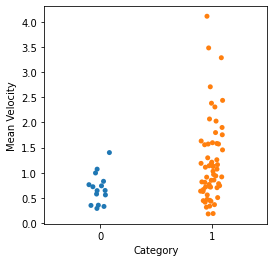

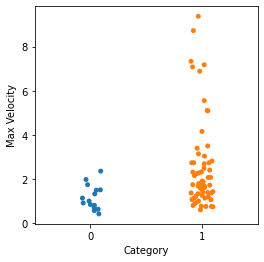

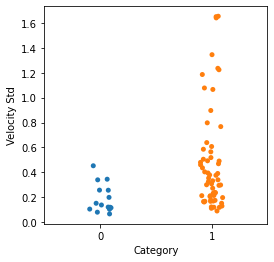

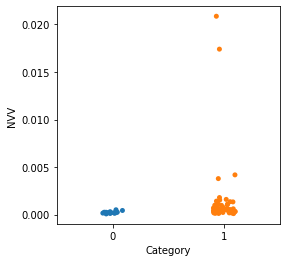

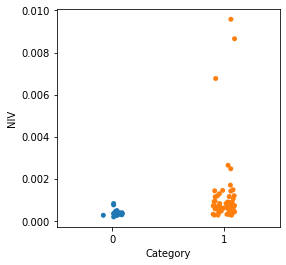

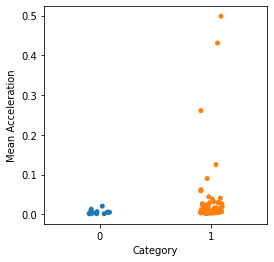

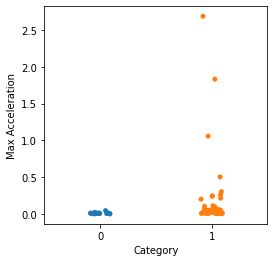

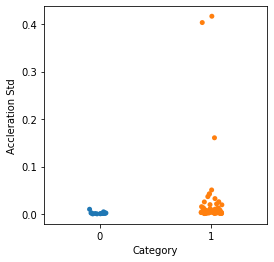

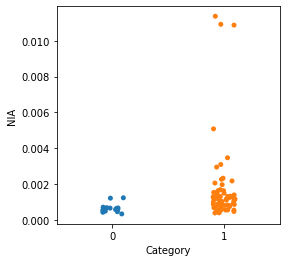

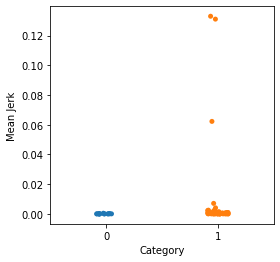

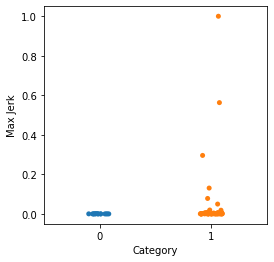

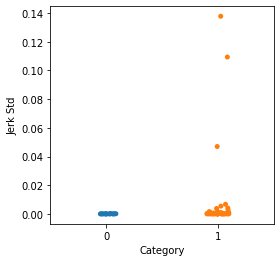

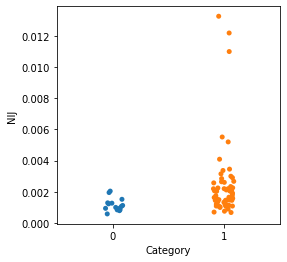

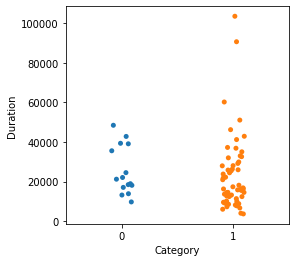

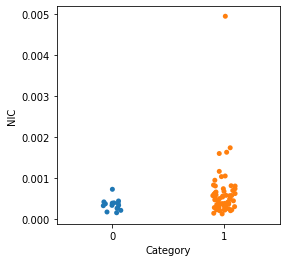

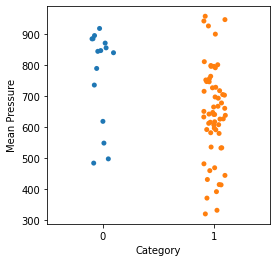

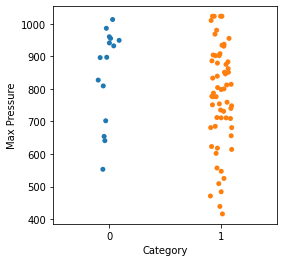

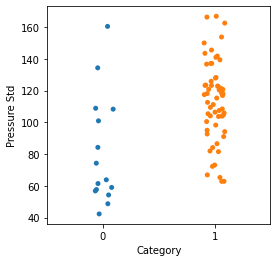

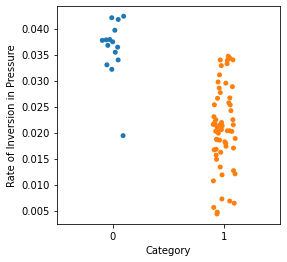

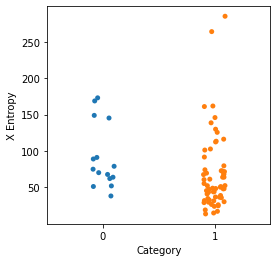

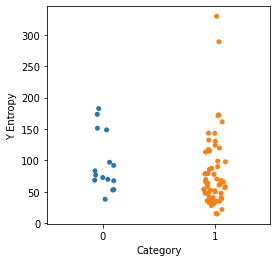

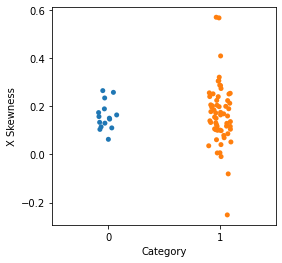

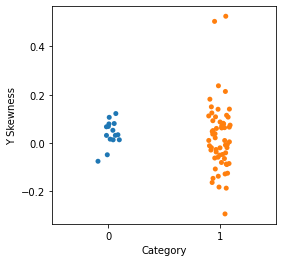

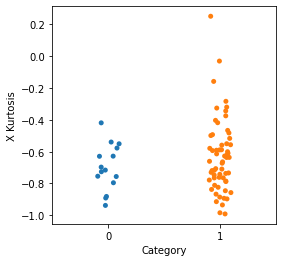

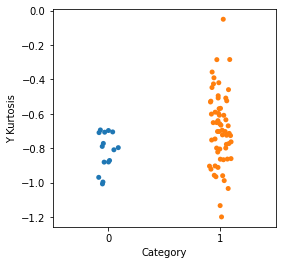

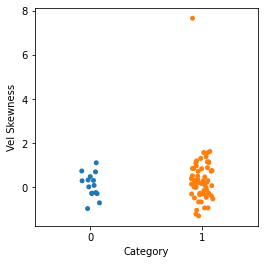

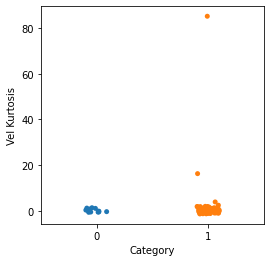

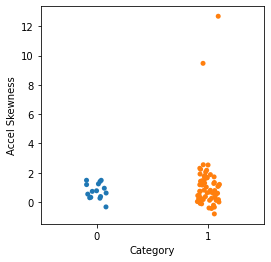

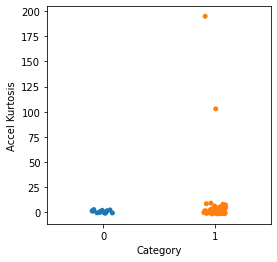

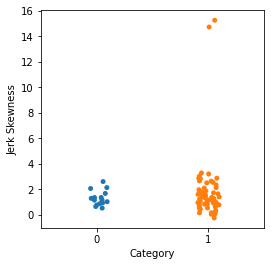

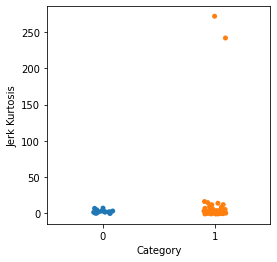

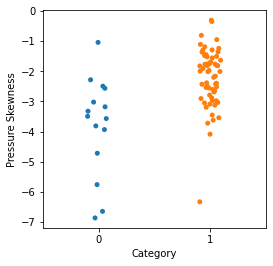

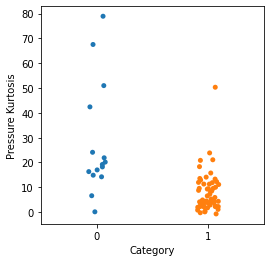

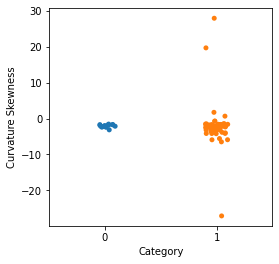

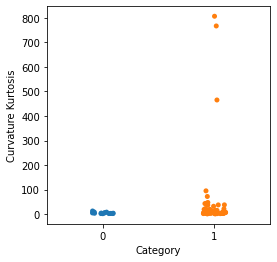

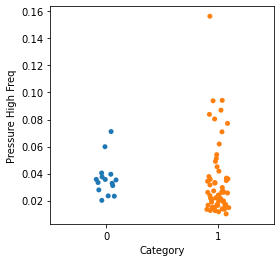

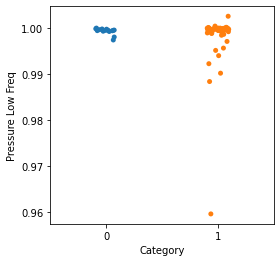

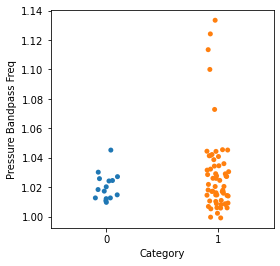

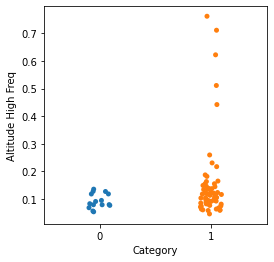

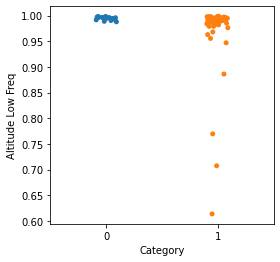

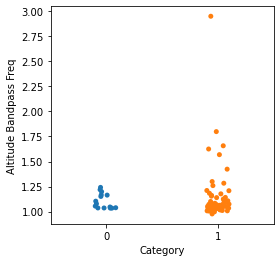

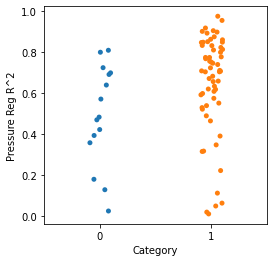

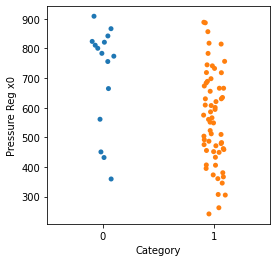

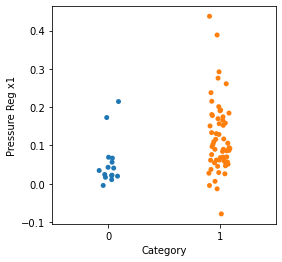

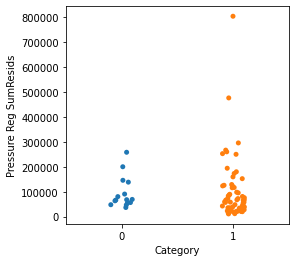

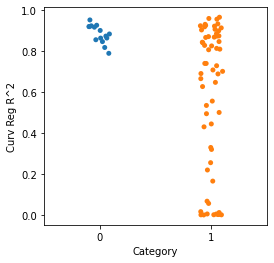

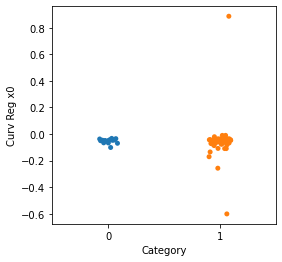

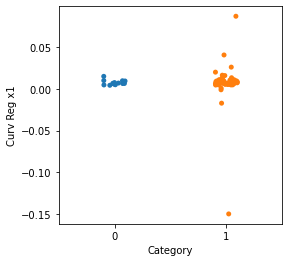

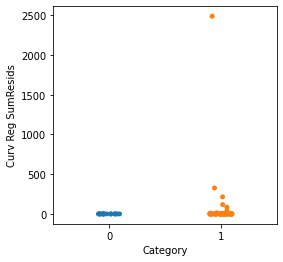

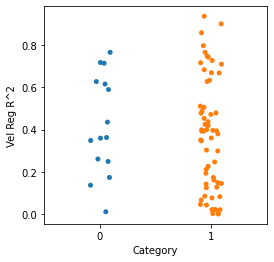

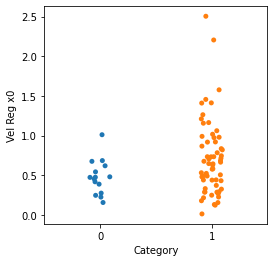

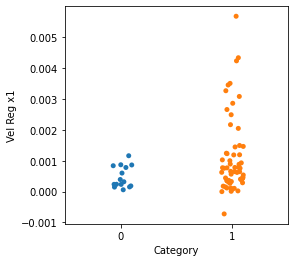

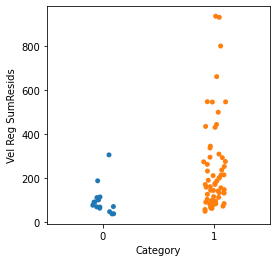

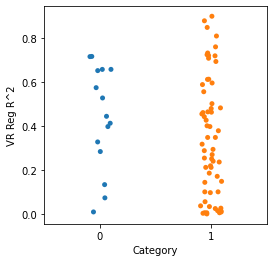

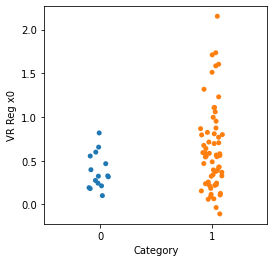

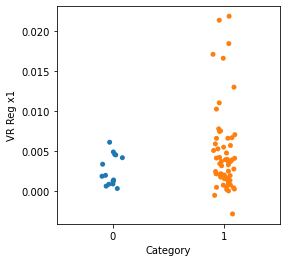

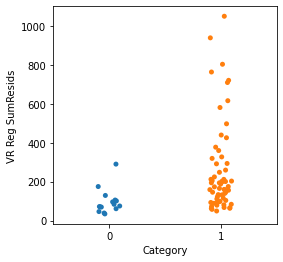

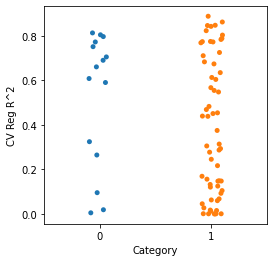

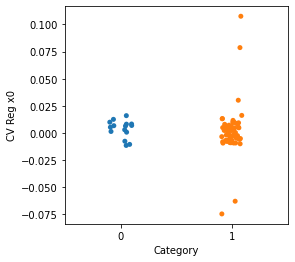

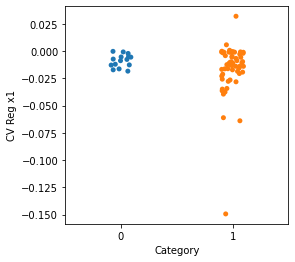

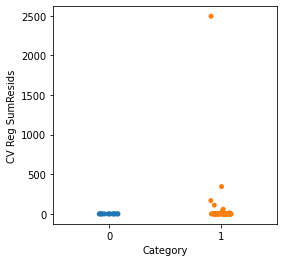

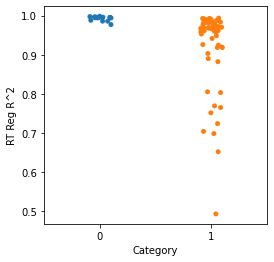

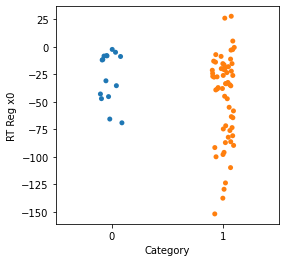

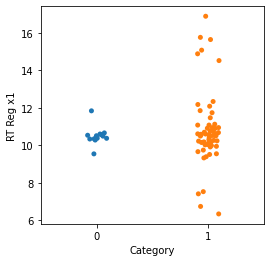

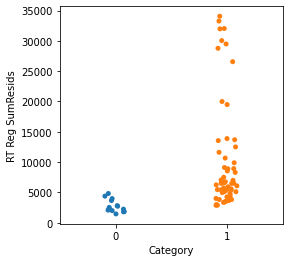

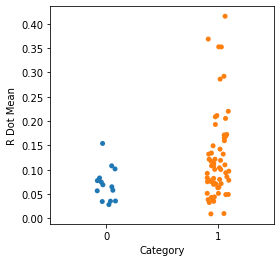

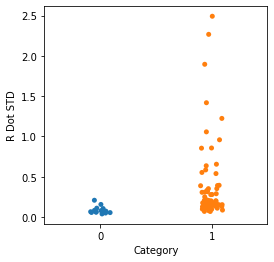

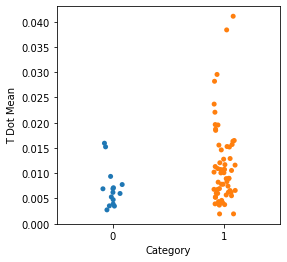

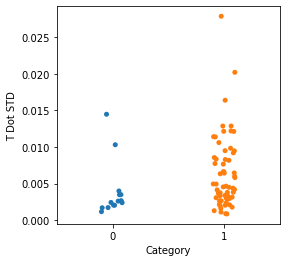

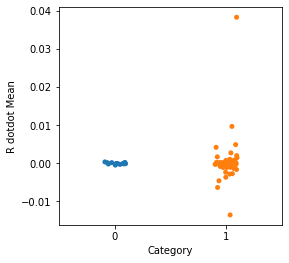

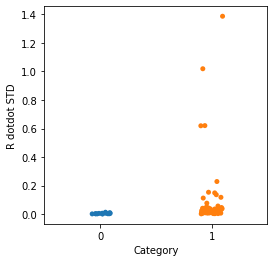

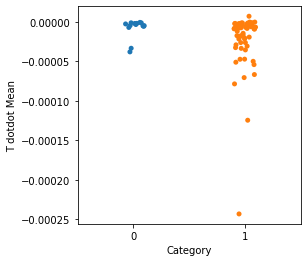

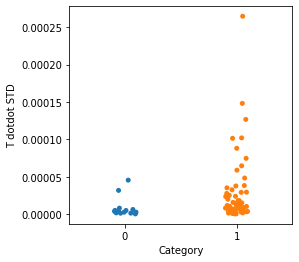

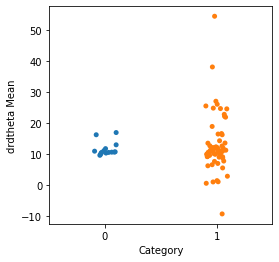

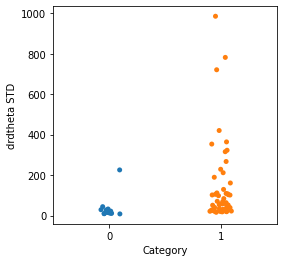

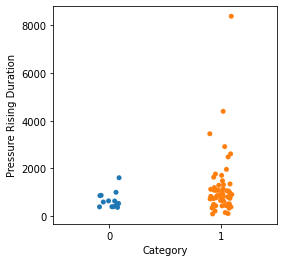

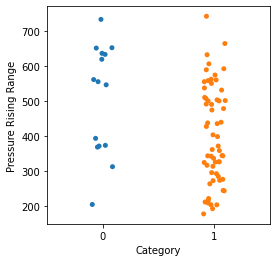

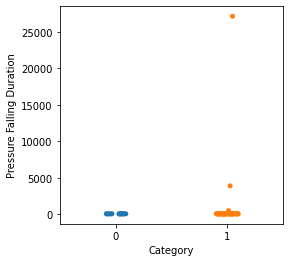

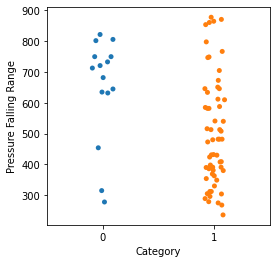

In [ ]:
for i in df_all_features_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_static['Category'], y = df_all_features_static[i])

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn

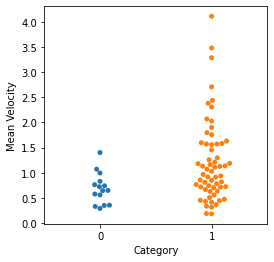

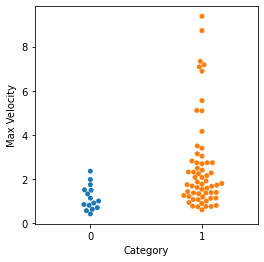

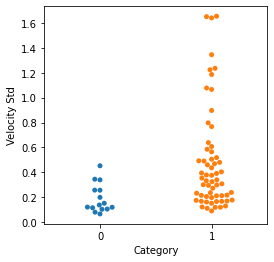

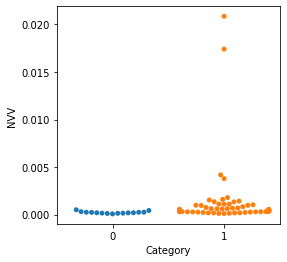

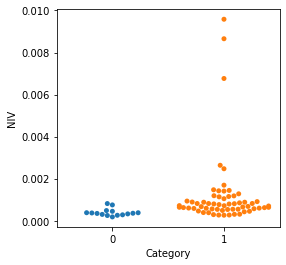

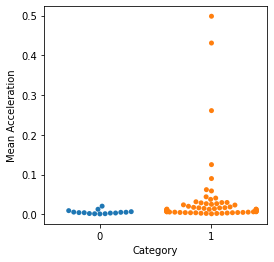

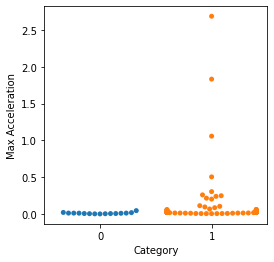

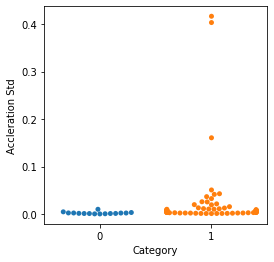

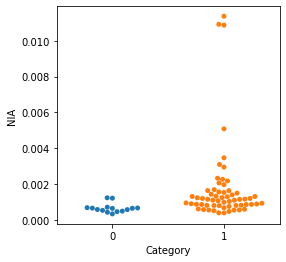

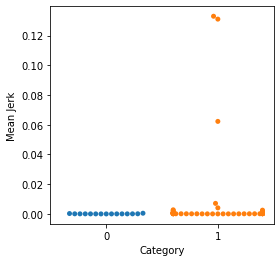

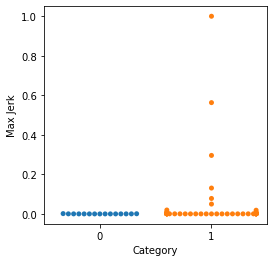

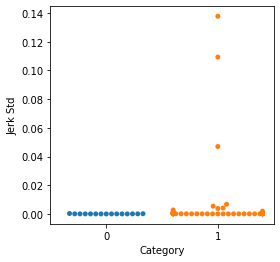

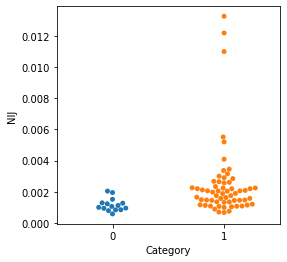

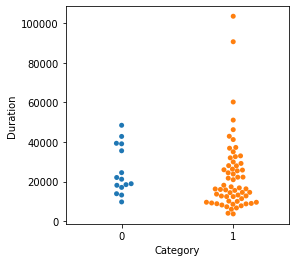

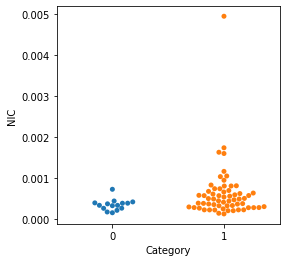

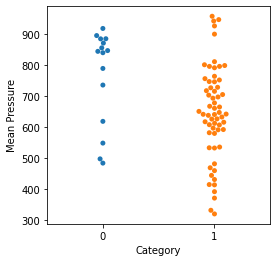

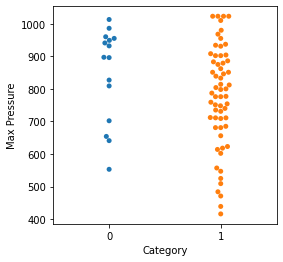

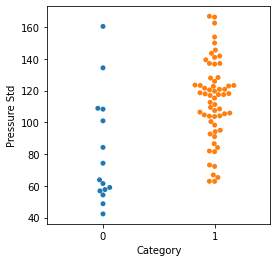

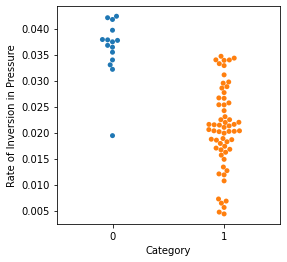

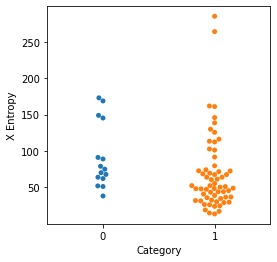

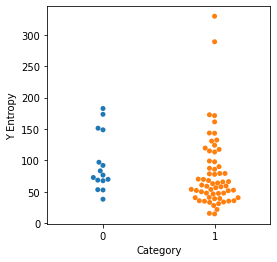

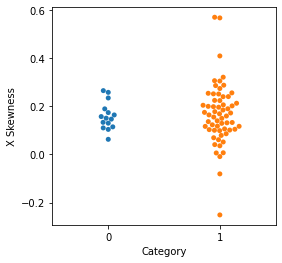

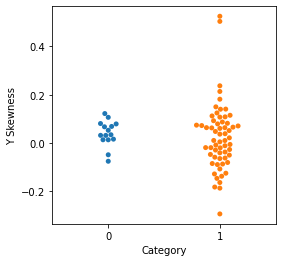

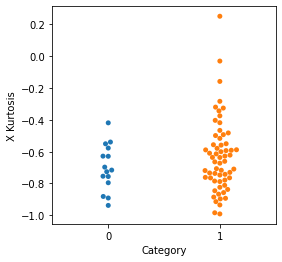

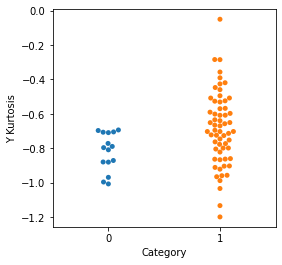

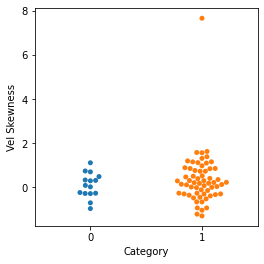

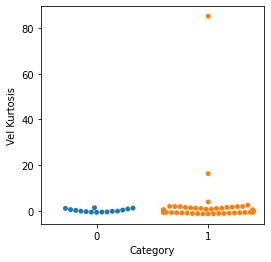

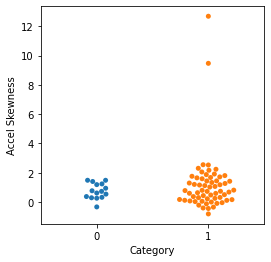

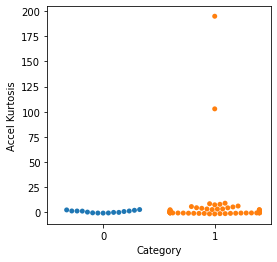

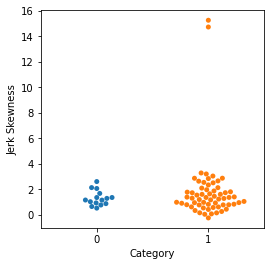

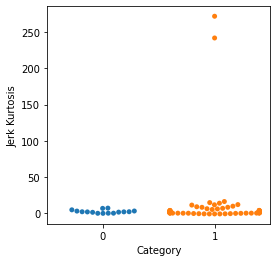

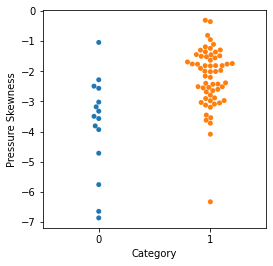

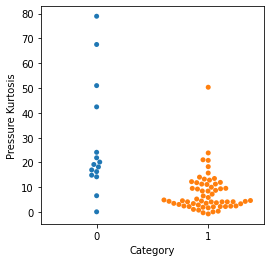

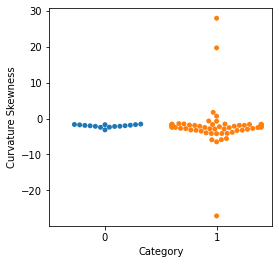

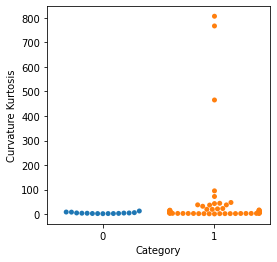

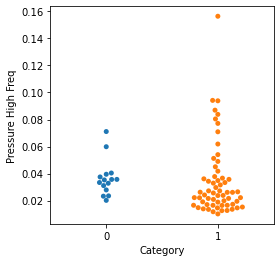

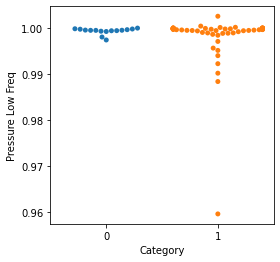

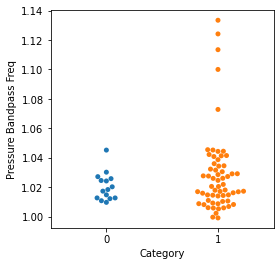

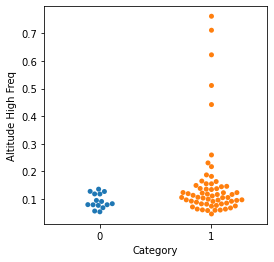

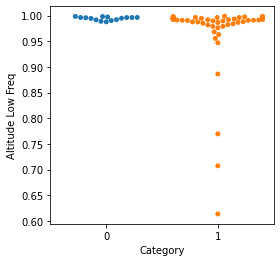

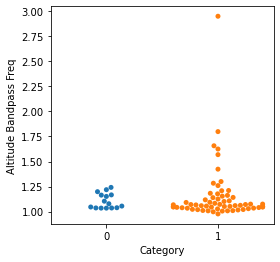

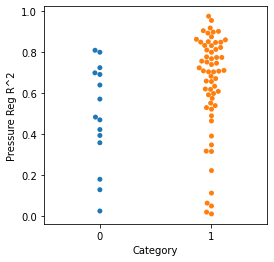

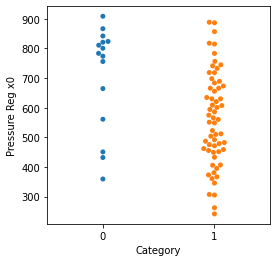

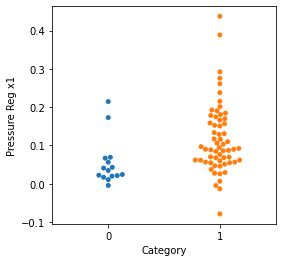

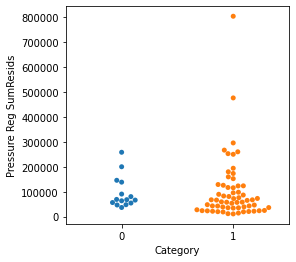

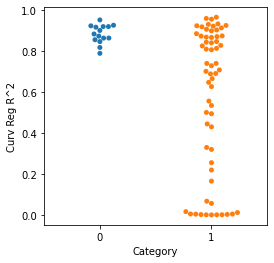

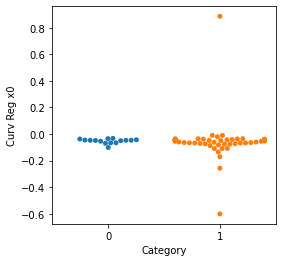

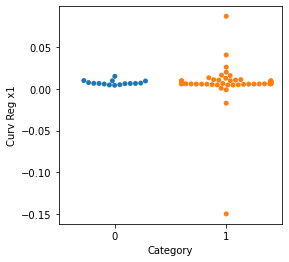

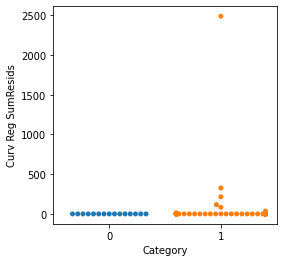

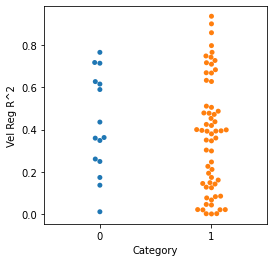

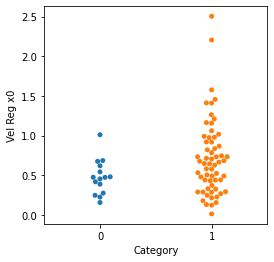

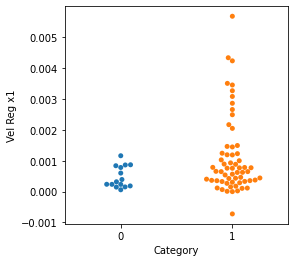

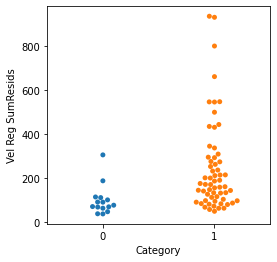

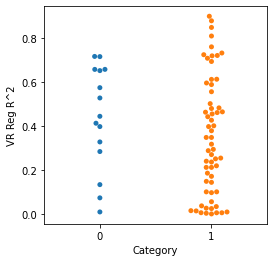

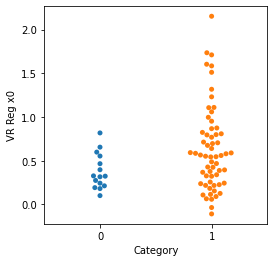

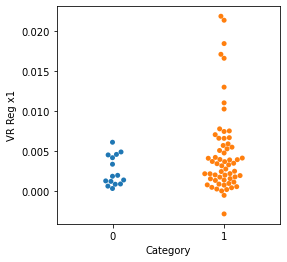

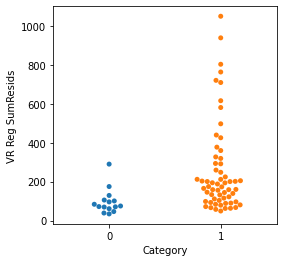

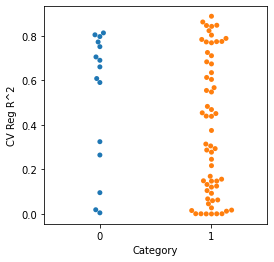

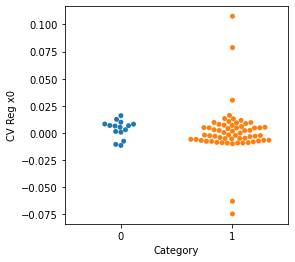

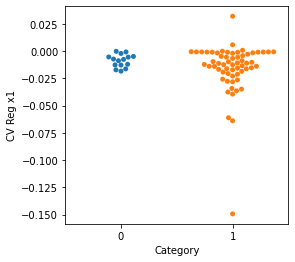

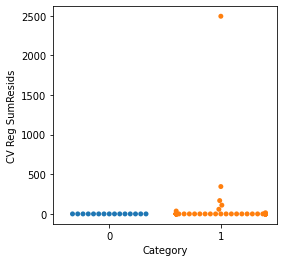

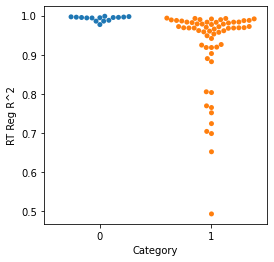

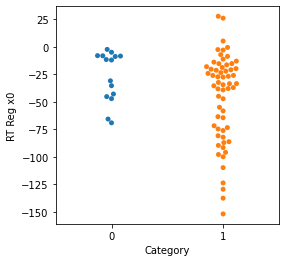

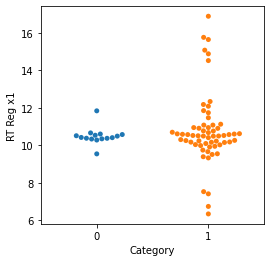

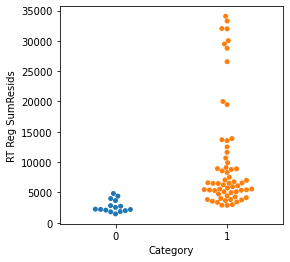

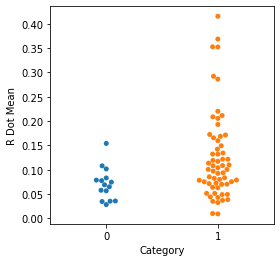

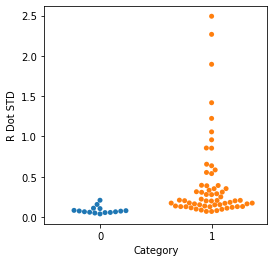

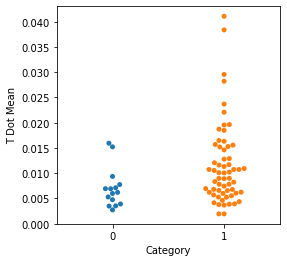

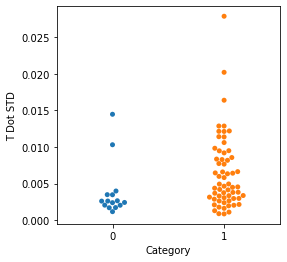

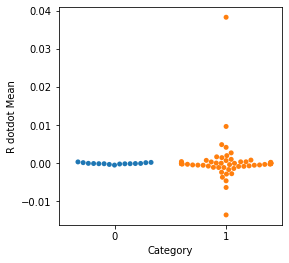

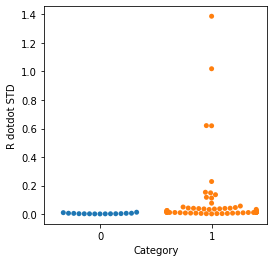

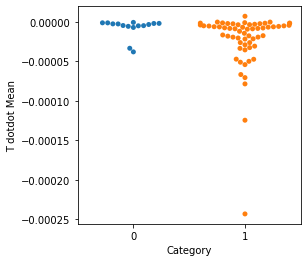

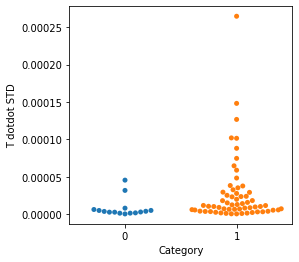

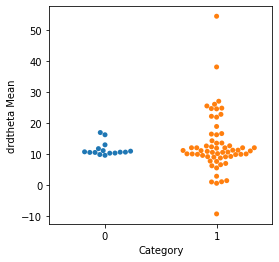

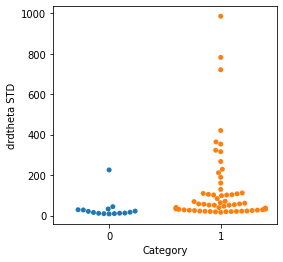

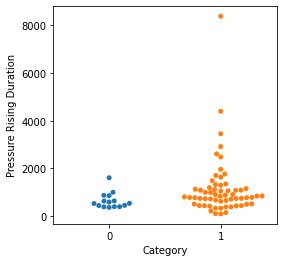

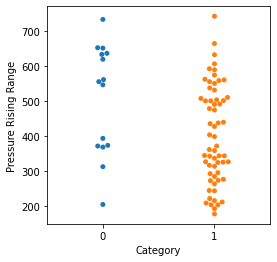

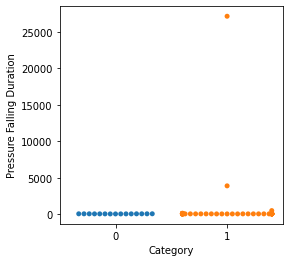

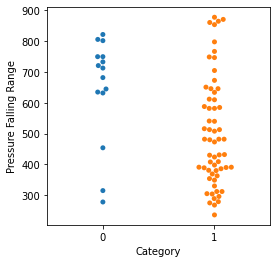

In [ ]:
for i in df_all_features_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.swarmplot(x = df_all_features_static['Category'], y = df_all_features_static[i])

In [ ]:
# CALCULATE ALL dynamic FEATURES AND PUT INTO DATAFRAME

dynamic_subject_id = []
dynamic_category = []
dynamic_mean_vel = []
dynamic_max_vel = []
dynamic_vel_std = []
dynamic_nvv = []
dynamic_vel_niv = [] #rate
dynamic_mean_accel = []
dynamic_max_accel = []
dynamic_std_accel = []
dynamic_nia = [] #rate
dynamic_mean_jerk = []
dynamic_max_jerk = []
dynamic_std_jerk = []
dynamic_nij = [] #rate
dynamic_duration = []
dynamic_nic = []
dynamic_mean_pressure = []
dynamic_max_pressure = []
dynamic_std_pressure = []
dynamic_rate_ip = []
dynamic_x_entropy = []
dynamic_y_entropy = []
dynamic_x_skewness = []
dynamic_y_skewness = []
dynamic_x_kurtosis = []
dynamic_y_kurtosis = []
dynamic_vel_skewness = []
dynamic_vel_kurtosis = []
dynamic_accel_skewness = []
dynamic_accel_kurtosis = []
dynamic_jerk_skewness = []
dynamic_jerk_kurtosis = []
dynamic_pressure_skewness = []
dynamic_pressure_kurtosis = []
dynamic_curv_skewness = []
dynamic_curv_kurtosis = []
dynamic_pressure_high_freq = []
dynamic_pressure_low_freq = []
dynamic_pressure_bandpass_freq = []
dynamic_altitude_high_freq = []
dynamic_altitude_low_freq = []
dynamic_altitude_bandpass_freq = []
dynamic_pressure_reg_r2 = []
dynamic_pressure_reg_x0 = []
dynamic_pressure_reg_x1 = []
dynamic_pressure_reg_sumresids = []
dynamic_curv_reg_r2 = []
dynamic_curv_reg_x0 = []
dynamic_curv_reg_x1 = []
dynamic_curv_reg_sumresids = []
dynamic_vel_reg_r2 = []
dynamic_vel_reg_x0 = []
dynamic_vel_reg_x1 = []
dynamic_vel_reg_sumresids = []

dynamic_VR_reg_r2 = []
dynamic_VR_reg_x0 = []
dynamic_VR_reg_x1 = []
dynamic_VR_reg_sumresids = []
dynamic_CV_reg_r2 = []
dynamic_CV_reg_x0 = []
dynamic_CV_reg_x1 = []
dynamic_CV_reg_sumresids = []
dynamic_RT_reg_r2 = []
dynamic_RT_reg_x0 = []
dynamic_RT_reg_x1 = []
dynamic_RT_reg_sumresids = []
dynamic_rdot_mean = []
dynamic_rdot_std = []
dynamic_tdot_mean = []
dynamic_tdot_std = []
dynamic_rdotdot_mean = []
dynamic_rdotdot_std = []
dynamic_tdotdot_mean = []
dynamic_tdotdot_std = []
dynamic_drdtheta_mean = []
dynamic_drdtheta_std = []

dynamic_pressure_rising_duration = []
dynamic_pressure_rising_range = []
dynamic_pressure_falling_duration = []
dynamic_pressure_falling_range = []

for filename in controlFiles:
    print(filename)
    # retrieve all preprocessed data

    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = dynamic_calculate(filename)

    # 0 is for control
    dynamic_category.append(0)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_vel_skewness.append(z)
    dynamic_vel_kurtosis.append(a1)
    dynamic_accel_skewness.append(b1)
    dynamic_accel_kurtosis.append(c1)
    dynamic_jerk_skewness.append(d1)
    dynamic_jerk_kurtosis.append(e1)
    dynamic_pressure_skewness.append(f1)
    dynamic_pressure_kurtosis.append(g1)
    dynamic_curv_skewness.append(h1)
    dynamic_curv_kurtosis.append(i1)
    dynamic_pressure_high_freq.append(j1)
    dynamic_pressure_low_freq.append(k1)
    dynamic_pressure_bandpass_freq.append(l1)
    dynamic_altitude_high_freq.append(m1)
    dynamic_altitude_low_freq.append(n1)
    dynamic_altitude_bandpass_freq.append(o1)
    dynamic_pressure_reg_r2.append(p1)
    dynamic_pressure_reg_x0.append(q1)
    dynamic_pressure_reg_x1.append(r1)
    dynamic_pressure_reg_sumresids.append(s1)
    dynamic_curv_reg_r2.append(t1)
    dynamic_curv_reg_x0.append(u1)
    dynamic_curv_reg_x1.append(v1)
    dynamic_curv_reg_sumresids.append(w1)
    dynamic_vel_reg_r2.append(x1)
    dynamic_vel_reg_x0.append(y1)
    dynamic_vel_reg_x1.append(z1)
    dynamic_vel_reg_sumresids.append(a2)

    dynamic_VR_reg_r2.append(b2)
    dynamic_VR_reg_x0.append(c2)
    dynamic_VR_reg_x1.append(d2)
    dynamic_VR_reg_sumresids.append(e2)
    dynamic_CV_reg_r2.append(f2)
    dynamic_CV_reg_x0.append(g2)
    dynamic_CV_reg_x1.append(h2)
    dynamic_CV_reg_sumresids.append(i2)
    dynamic_RT_reg_r2.append(j2)
    dynamic_RT_reg_x0.append(k2)
    dynamic_RT_reg_x1.append(l2)
    dynamic_RT_reg_sumresids.append(m2)
    dynamic_rdot_mean.append(n2)
    dynamic_rdot_std.append(o2)
    dynamic_tdot_mean.append(p2)
    dynamic_tdot_std.append(q2)
    dynamic_rdotdot_mean.append(r2)
    dynamic_rdotdot_std.append(s2)
    dynamic_tdotdot_mean.append(t2)
    dynamic_tdotdot_std.append(u2)
    dynamic_drdtheta_mean.append(v2)
    dynamic_drdtheta_std.append(w2)

    dynamic_pressure_rising_duration.append(x2)
    dynamic_pressure_rising_range.append(y2)
    dynamic_pressure_falling_duration.append(z2)
    dynamic_pressure_falling_range.append(a3)

# remove the following file because it doesn't have a dynamic component
# patientFiles.remove('/work/ParkinsonHW/H_P000-0021.txt')
for filename in patientFiles:
    print(filename)
    # retrieve all preprocessed data
    (dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

    (a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = dynamic_calculate(filename)

    # 1 is for patient
    dynamic_category.append(1)
    dynamic_subject_id.append(filename)
    dynamic_mean_vel.append(a)
    dynamic_max_vel.append(b)
    dynamic_vel_std.append(c)
    dynamic_nvv.append(d)
    dynamic_vel_niv.append(e) # rate
    dynamic_mean_accel.append(f)
    dynamic_max_accel.append(g)
    dynamic_std_accel.append(h)
    dynamic_nia.append(i) #rate
    dynamic_mean_jerk.append(j)
    dynamic_max_jerk.append(k)
    dynamic_std_jerk.append(l)
    dynamic_nij.append(m) #rate
    dynamic_duration.append(n)
    dynamic_nic.append(o)
    dynamic_mean_pressure.append(p)
    dynamic_max_pressure.append(q)
    dynamic_std_pressure.append(r)
    dynamic_rate_ip.append(s)
    dynamic_x_entropy.append(t)
    dynamic_y_entropy.append(u)
    dynamic_x_skewness.append(v)
    dynamic_y_skewness.append(w)
    dynamic_x_kurtosis.append(x)
    dynamic_y_kurtosis.append(y)
    dynamic_vel_skewness.append(z)
    dynamic_vel_kurtosis.append(a1)
    dynamic_accel_skewness.append(b1)
    dynamic_accel_kurtosis.append(c1)
    dynamic_jerk_skewness.append(d1)
    dynamic_jerk_kurtosis.append(e1)
    dynamic_pressure_skewness.append(f1)
    dynamic_pressure_kurtosis.append(g1)
    dynamic_curv_skewness.append(h1)
    dynamic_curv_kurtosis.append(i1)
    dynamic_pressure_high_freq.append(j1)
    dynamic_pressure_low_freq.append(k1)
    dynamic_pressure_bandpass_freq.append(l1)
    dynamic_altitude_high_freq.append(m1)
    dynamic_altitude_low_freq.append(n1)
    dynamic_altitude_bandpass_freq.append(o1)
    dynamic_pressure_reg_r2.append(p1)
    dynamic_pressure_reg_x0.append(q1)
    dynamic_pressure_reg_x1.append(r1)
    dynamic_pressure_reg_sumresids.append(s1)
    dynamic_curv_reg_r2.append(t1)
    dynamic_curv_reg_x0.append(u1)
    dynamic_curv_reg_x1.append(v1)
    dynamic_curv_reg_sumresids.append(w1)
    dynamic_vel_reg_r2.append(x1)
    dynamic_vel_reg_x0.append(y1)
    dynamic_vel_reg_x1.append(z1)
    dynamic_vel_reg_sumresids.append(a2)

    dynamic_VR_reg_r2.append(b2)
    dynamic_VR_reg_x0.append(c2)
    dynamic_VR_reg_x1.append(d2)
    dynamic_VR_reg_sumresids.append(e2)
    dynamic_CV_reg_r2.append(f2)
    dynamic_CV_reg_x0.append(g2)
    dynamic_CV_reg_x1.append(h2)
    dynamic_CV_reg_sumresids.append(i2)
    dynamic_RT_reg_r2.append(j2)
    dynamic_RT_reg_x0.append(k2)
    dynamic_RT_reg_x1.append(l2)
    dynamic_RT_reg_sumresids.append(m2)
    dynamic_rdot_mean.append(n2)
    dynamic_rdot_std.append(o2)
    dynamic_tdot_mean.append(p2)
    dynamic_tdot_std.append(q2)
    dynamic_rdotdot_mean.append(r2)
    dynamic_rdotdot_std.append(s2)
    dynamic_tdotdot_mean.append(t2)
    dynamic_tdotdot_std.append(u2)
    dynamic_drdtheta_mean.append(v2)
    dynamic_drdtheta_std.append(w2)

    dynamic_pressure_rising_duration.append(x2)
    dynamic_pressure_rising_range.append(y2)
    dynamic_pressure_falling_duration.append(z2)
    dynamic_pressure_falling_range.append(a3)

df_all_features_dynamic = pd.DataFrame({'dynamic Subject ID': dynamic_subject_id, 'Category': dynamic_category,
'Mean Velocity': dynamic_mean_vel, 'Max Velocity': dynamic_max_vel, 'Velocity Std': dynamic_vel_std, 'NVV': dynamic_nvv, 'NIV': dynamic_vel_niv,
'Mean Acceleration': dynamic_mean_accel, 'Max Acceleration': dynamic_max_accel, 'Accleration Std': dynamic_std_accel, 'NIA': dynamic_nia,
'Mean Jerk': dynamic_mean_jerk, 'Max Jerk': dynamic_max_jerk, 'Jerk Std': dynamic_std_jerk, 'NIJ': dynamic_nij,
'Duration': dynamic_duration, 'NIC': dynamic_nic,
'Mean Pressure': dynamic_mean_pressure, 'Max Pressure': dynamic_max_pressure, 'Pressure Std': dynamic_std_pressure, 'Rate of Inversion in Pressure': dynamic_rate_ip,
'X Entropy': dynamic_x_entropy, 'Y Entropy': dynamic_y_entropy,
'X Skewness': dynamic_x_skewness, 'Y Skewness': dynamic_y_skewness, 'X Kurtosis': dynamic_x_kurtosis, 'Y Kurtosis': dynamic_y_kurtosis,
'Vel Skewness': dynamic_vel_skewness, 'Vel Kurtosis': dynamic_vel_kurtosis, 'Accel Skewness': dynamic_accel_skewness, 'Accel Kurtosis': dynamic_accel_kurtosis,
'Jerk Skewness': dynamic_jerk_skewness, 'Jerk Kurtosis': dynamic_jerk_kurtosis,
'Pressure Skewness': dynamic_pressure_skewness, 'Pressure Kurtosis': dynamic_pressure_kurtosis,
'Curvature Skewness': dynamic_curv_skewness, 'Curvature Kurtosis': dynamic_curv_kurtosis,
'Pressure High Freq': dynamic_pressure_high_freq, 'Pressure Low Freq': dynamic_pressure_low_freq, 'Pressure Bandpass Freq': dynamic_pressure_bandpass_freq,
'Altitude High Freq': dynamic_altitude_high_freq, 'Altitude Low Freq': dynamic_altitude_low_freq, 'Altitude Bandpass Freq': dynamic_altitude_bandpass_freq,
'Pressure Reg R^2': dynamic_pressure_reg_r2, 'Pressure Reg x0': dynamic_pressure_reg_x0, 'Pressure Reg x1': dynamic_pressure_reg_x1, 'Pressure Reg SumResids': dynamic_pressure_reg_sumresids,
'Curv Reg R^2': dynamic_curv_reg_r2, 'Curv Reg x0': dynamic_curv_reg_x0, 'Curv Reg x1': dynamic_curv_reg_x1, 'Curv Reg SumResids': dynamic_curv_reg_sumresids,
'Vel Reg R^2': dynamic_vel_reg_r2, 'Vel Reg x0': dynamic_vel_reg_x0, 'Vel Reg x1': dynamic_vel_reg_x1, 'Vel Reg SumResids': dynamic_vel_reg_sumresids,
'VR Reg R^2': dynamic_VR_reg_r2, 'VR Reg x0': dynamic_VR_reg_x0, 'VR Reg x1': dynamic_VR_reg_x1, 'VR Reg SumResids': dynamic_VR_reg_sumresids,
'CV Reg R^2': dynamic_CV_reg_r2, 'CV Reg x0': dynamic_CV_reg_x0, 'CV Reg x1': dynamic_CV_reg_x1, 'CV Reg SumResids': dynamic_CV_reg_sumresids,
'RT Reg R^2': dynamic_RT_reg_r2, 'RT Reg x0': dynamic_RT_reg_x0, 'RT Reg x1': dynamic_RT_reg_x1, 'RT Reg SumResids': dynamic_RT_reg_sumresids,
'R Dot Mean': dynamic_rdot_mean, 'R Dot STD': dynamic_rdot_std, 'T Dot Mean': dynamic_tdot_mean, 'T Dot STD': dynamic_tdot_std,
'R dotdot Mean': dynamic_rdotdot_mean, 'R dotdot STD': dynamic_rdotdot_std, 'T dotdot Mean': dynamic_tdotdot_mean, 'T dotdot STD': dynamic_tdotdot_std,
'drdtheta Mean': dynamic_drdtheta_mean, 'drdtheta STD': dynamic_drdtheta_std,
'Pressure Rising Duration': dynamic_pressure_rising_duration, 'Pressure Rising Range': dynamic_pressure_rising_range,
'Pressure Falling Duration': dynamic_pressure_falling_duration, 'Pressure Falling Range': dynamic_pressure_falling_range})

/work/ParkinsonHW/C_0001.txt
/work/feature_functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:192: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  logprob = kde.score_samples(data[:, None])
/work/feature_functions.py:191: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde = KernelDensity(kernel='gaussian', bandwidth=10).fit(data[:, None])
/work/feature_functions.py:192: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be re

In [ ]:
filename = '/work/ParkinsonHW/H_P000-0019.txt'
df = pd.read_csv(filename, header = None, sep = ";")
df_static, dynamic_df = staticDynamicSplit(df)
if dynamic_df.empty:
    print('dataframe is empty')
(dynamic_time, dynamic_x, dynamic_y, dynamic_radius, dynamic_theta, dynamic_velocity, dynamic_acceleration,
    dynamic_jerk, dynamic_rdot, dynamic_tdot, dynamic_rdotdot, dynamic_tdotdot, dynamic_drdtheta, dynamic_curvature,
    dynamic_pressure, dynamic_risingIndex, dynamic_fallingIndex, dynamic_pressure_rising, dynamic_pressure_main,
    dynamic_pressure_falling, dynamic_altitude) = dynamic_preprocessing(filename)

print(dynamic_x)
'''
(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,
    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,
    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,
    a3) = dynamic_calculate(filename)'''

dataframe is empty
nan


'\n(a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z,\n    a1,b1,c1,d1,e1,f1,g1,h1,i1,j1,k1,l1,m1,n1,o1,p1,q1,r1,s1,t1,u1,v1,w1,x1,y1,z1,\n    a2,b2,c2,d2,e2,f2,g2,h2,i2,j2,k2,l2,m2,n2,o2,p2,q2,r2,s2,t2,u2,v2,w2,x2,y2,z2,\n    a3) = dynamic_calculate(filename)'

In [ ]:
df_all_features_dynamic.to_csv ('Dynamic_HW_features.csv', index = False, header=True)

In [ ]:
df_all_features_static = pd.read_csv('/work/Static_HW_features.csv')
df_all_features_static

Static Subject ID  Category  Mean Velocity  Max Velocity  \
0        /work/ParkinsonHW/C_0001.txt         0       0.763353      1.508147   
1        /work/ParkinsonHW/C_0002.txt         0       0.559823      1.001812   
2        /work/ParkinsonHW/C_0003.txt         0       0.577474      0.808143   
3        /work/ParkinsonHW/C_0004.txt         0       0.645112      1.133661   
4        /work/ParkinsonHW/C_0005.txt         0       0.995901      1.976179   
..                                ...       ...            ...           ...   
71   /work/ParkinsonHW/P_26060007.txt         1       0.766646      2.073436   
72  /work/ParkinsonHW/H_P000-0035.txt         1       2.026080      9.373600   
73  /work/ParkinsonHW/H_p000-0018.txt         1       0.452617      0.801572   
74   /work/ParkinsonHW/P_23100002.txt         1       0.635284      1.069605   
75  /work/ParkinsonHW/H_P000-0032.txt         1       1.556340      2.273901   

    Velocity Std       NVV       NIV  Mean Acceleration  Max Acceleration  \
0       0.256847  0.000199  0.000386           0.005358          0.012816   
1       0.137363  0.000238  0.000285           0.003091          0.006730   
2       0.119065  0.000142  0.000253           0.002888          0.006152   
3       0.151134  0.000251  0.000330           0.004083          0.012296   
4       0.344574  0.000203  0.000360           0.009018          0.018844   
..           ...       ...       ...                ...               ...   
71      0.378668  0.000396  0.000642           0.006019          0.022859   
72      1.224294  0.017409  0.008655           0.431046          2.685503   
73      0.169099  0.000637  0.000719           0.003721          0.018696   
74      0.161262  0.000191  0.000274           0.003823          0.006819   
75      0.307547  0.000550  0.001445           0.023593          0.045754   

    Accleration Std  ...  R dotdot Mean  R dotdot STD  T dotdot Mean  \
0          0.002136  ...      -0.000290      0.003108      -0.000003   
1          0.001066  ...      -0.000100      0.002019      -0.000002   
2          0.001091  ...       0.000180      0.003554      -0.000003   
3          0.002318  ...      -0.000123      0.003338      -0.000005   
4          0.003200  ...      -0.000461      0.003006      -0.000006   
..              ...  ...            ...           ...            ...   
71         0.003773  ...      -0.000338      0.015033      -0.000002   
72         0.403142  ...      -0.013530      1.386249      -0.000033   
73         0.002739  ...      -0.000213      0.015425      -0.000003   
74         0.001408  ...       0.000037      0.004329      -0.000006   
75         0.009991  ...      -0.003651      0.043178      -0.000026   

    T dotdot STD  drdtheta Mean  drdtheta STD  Pressure Rising Duration  \
0       0.000004      10.610610      9.597464                       387   
1       0.000002      10.803881     11.155429                       387   
2       0.000003      11.830677     12.358261                       630   
3       0.000005      10.404557     15.273382                       626   
4       0.000006      10.601360      8.134354                       584   
..           ...            ...           ...                       ...   
71      0.000003      13.639552     35.132567                      4394   
72      0.000038      27.093770    322.825381                       614   
73      0.000004      18.972630     70.527852                       767   
74      0.000007      12.684681     32.778074                      1342   
75      0.000025       7.712653     37.284051                       324   

    Pressure Rising Range  Pressure Falling Duration  Pressure Falling Range  
0                     633                         50                     822  
1                     561                         43                     713  
2                     636                         54                     682  
3                     733                         42

In [ ]:
df_all_features_dynamic = pd.read_csv('/work/Dynamic_HW_features.csv')
df_all_features_dynamic

dynamic Subject ID  Category  Mean Velocity  Max Velocity  \
0        /work/ParkinsonHW/C_0001.txt         0       0.608264      1.038402   
1        /work/ParkinsonHW/C_0002.txt         0       0.570309      0.929899   
2        /work/ParkinsonHW/C_0003.txt         0       0.525343      0.963414   
3        /work/ParkinsonHW/C_0004.txt         0       0.648046      1.335771   
4        /work/ParkinsonHW/C_0005.txt         0       0.891953      1.579599   
..                                ...       ...            ...           ...   
71   /work/ParkinsonHW/P_26060007.txt         1       0.698569      1.957498   
72  /work/ParkinsonHW/H_P000-0035.txt         1       2.212872     13.076952   
73  /work/ParkinsonHW/H_p000-0018.txt         1            NaN           NaN   
74   /work/ParkinsonHW/P_23100002.txt         1       1.079148      2.172759   
75  /work/ParkinsonHW/H_P000-0032.txt         1       0.874963      1.285325   

    Velocity Std       NVV       NIV  Mean Acceleration  Max Acceleration  \
0       0.129533  0.000166  0.000353           0.003417          0.006625   
1       0.104160  0.000194  0.000427           0.003099          0.005938   
2       0.139191  0.000195  0.000328           0.002700          0.008736   
3       0.222400  0.000331  0.000460           0.004301          0.010183   
4       0.270280  0.000199  0.000575           0.007222          0.015176   
..           ...       ...       ...                ...               ...   
71      0.437480  0.000442  0.000483           0.006214          0.026428   
72      1.779768  0.018579  0.009523           0.480414          3.842637   
73           NaN       NaN       NaN                NaN               NaN   
74      0.384755  0.000287  0.000484           0.012620          0.029416   
75      0.231421  0.000541  0.000958           0.009464          0.022818   

    Accleration Std  ...  R dotdot Mean  R dotdot STD  T dotdot Mean  \
0          0.001501  ...      -0.000004      0.001645      -0.000004   
1          0.001374  ...       0.000046      0.002677      -0.000004   
2          0.001349  ...       0.000197      0.005942      -0.000002   
3          0.002125  ...       0.000157      0.004784      -0.000003   
4          0.002747  ...      -0.000651      0.006301      -0.000006   
..              ...  ...            ...           ...            ...   
71         0.004959  ...      -0.000098      0.009124      -0.000004   
72         0.510012  ...       0.007096      0.703655      -0.000010   
73              NaN  ...            NaN           NaN            NaN   
74         0.005136  ...      -0.000388      0.008315      -0.000005   
75         0.004842  ...      -0.001577      0.031355      -0.000019   

    T dotdot STD  drdtheta Mean  drdtheta STD  Pressure Rising Duration  \
0       0.000004      11.320021     14.241246                     704.0   
1       0.000004      11.196910     15.381997                     457.0   
2       0.000002      14.263745     28.395524                     702.0   
3       0.000004      11.241506     19.555250                     577.0   
4       0.000006      10.722401     15.824590                     506.0   
..           ...            ...           ...                       ...   
71      0.000005      13.473992     38.764131                    1533.0   
72      0.000002       5.691661    146.272575                     433.0   
73           NaN            NaN           NaN                       NaN   
74      0.000006       6.480644     17.627607                    1153.0   
75      0.000022      10.335813    236.500556                     598.0   

    Pressure Rising Range  Pressure Falling Duration  Pressure Falling Range  
0                   680.0                       50.0                   724.0  
1                   675.0                       49.0                   722.0  
2                   581.0                       63.0                   736.0  
3                   708.0                       49.

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


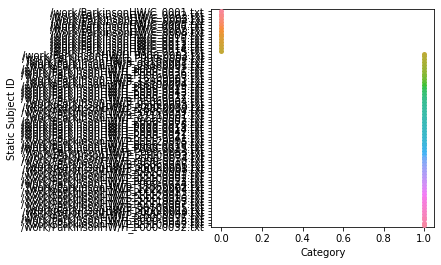

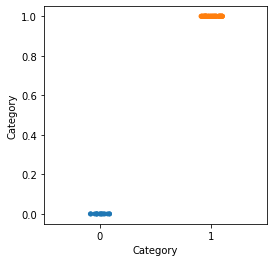

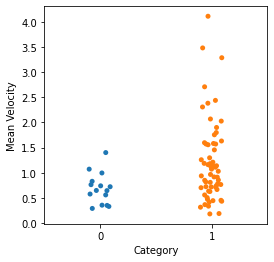

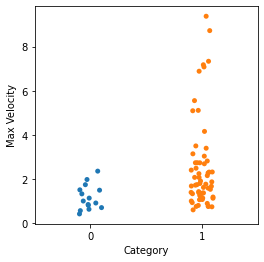

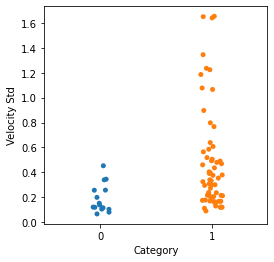

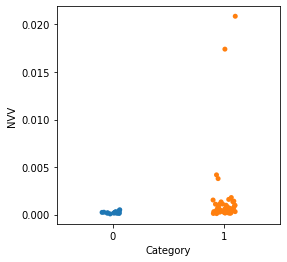

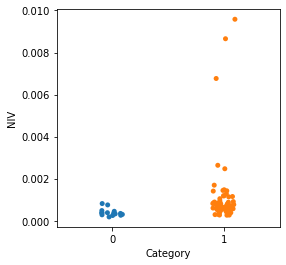

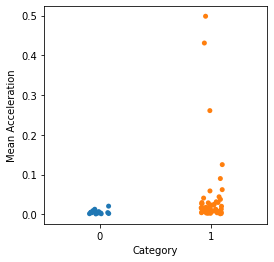

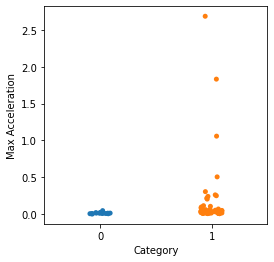

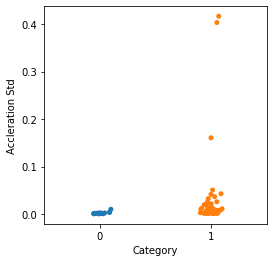

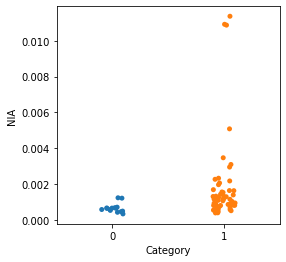

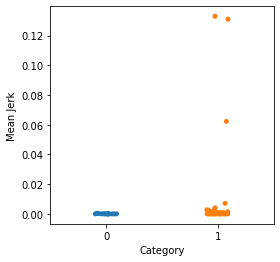

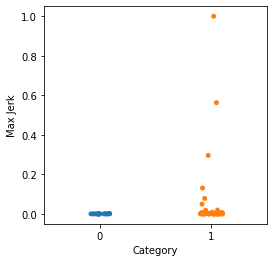

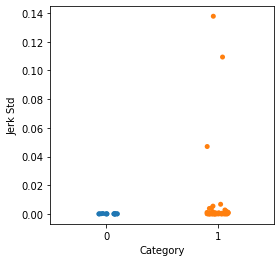

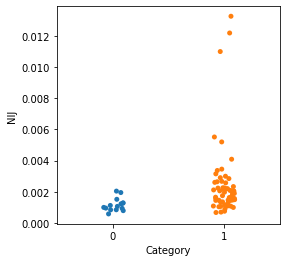

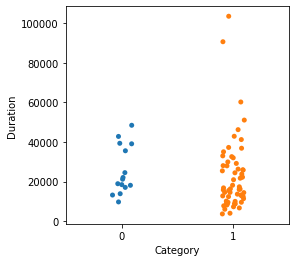

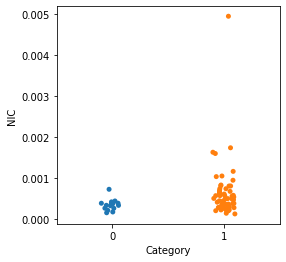

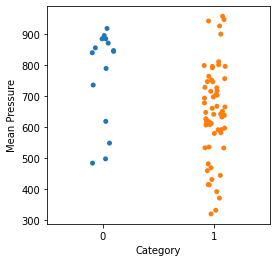

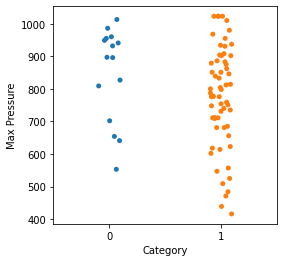

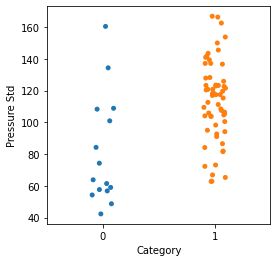

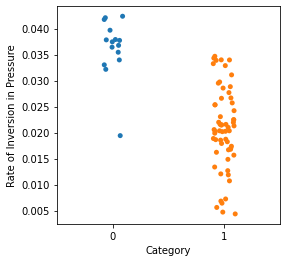

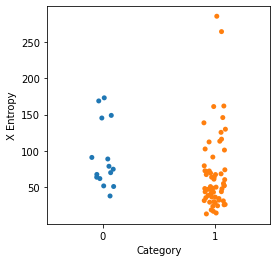

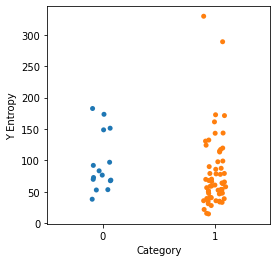

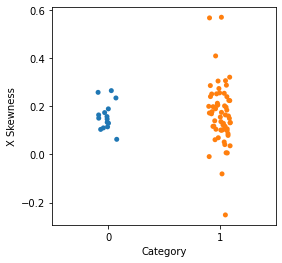

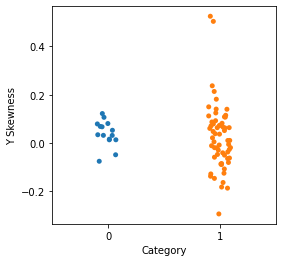

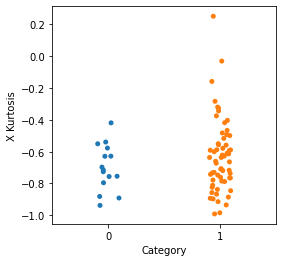

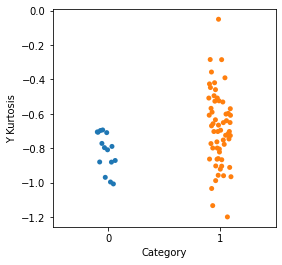

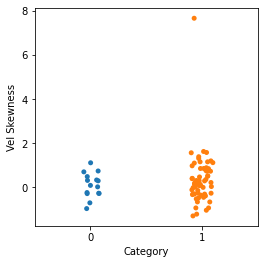

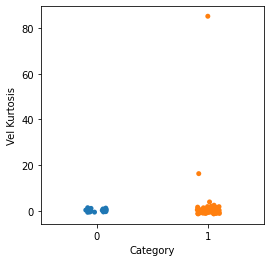

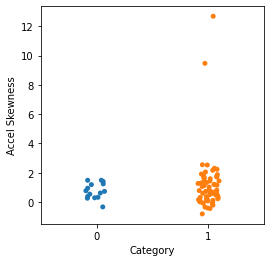

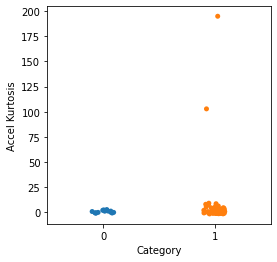

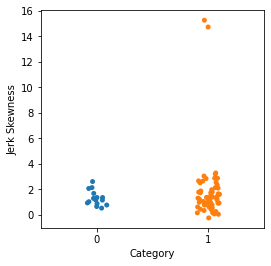

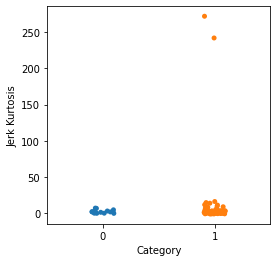

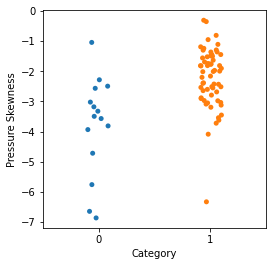

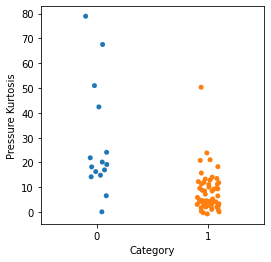

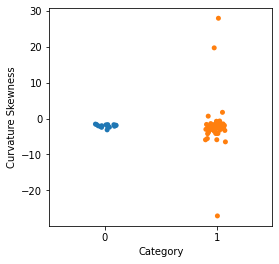

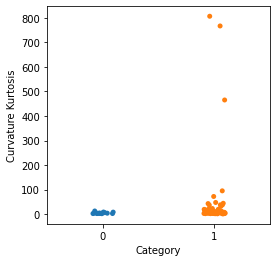

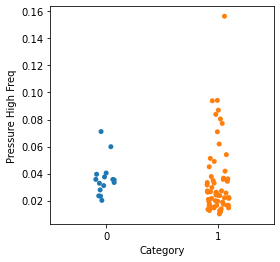

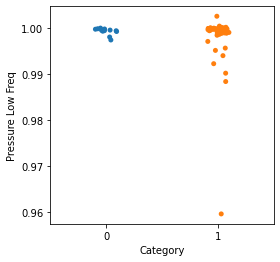

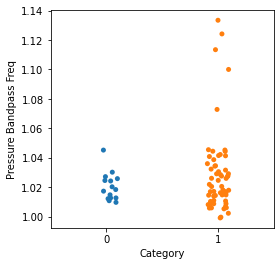

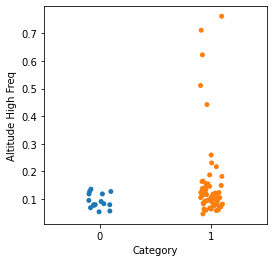

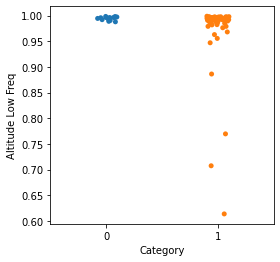

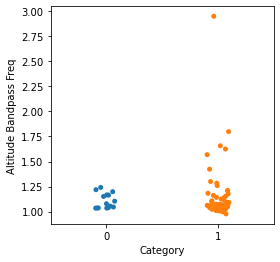

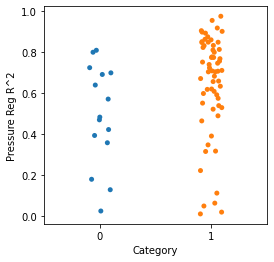

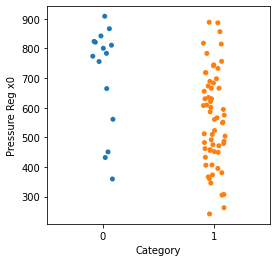

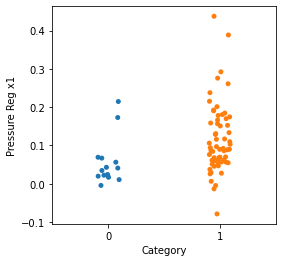

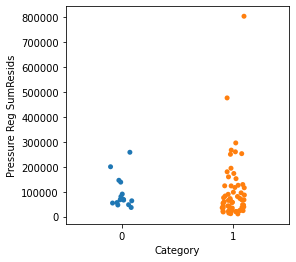

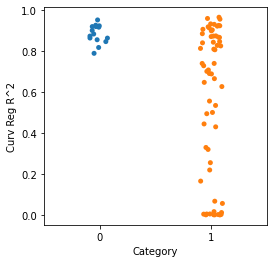

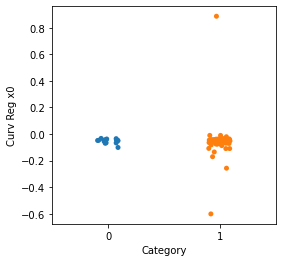

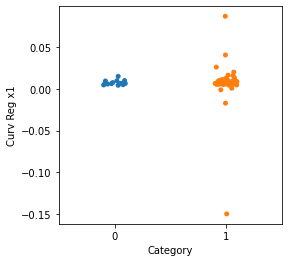

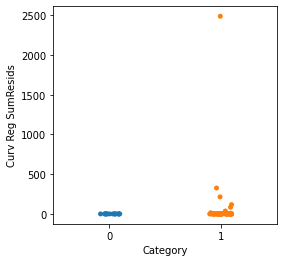

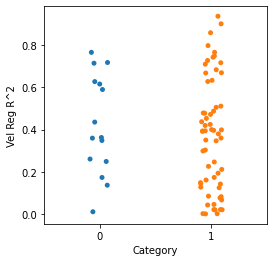

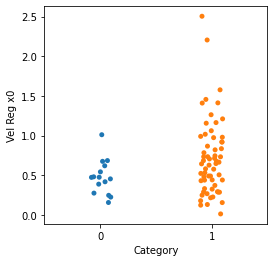

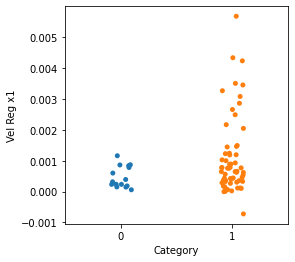

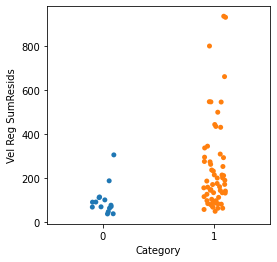

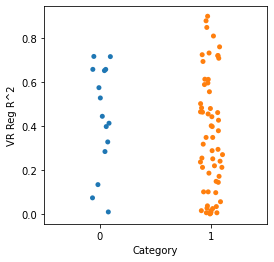

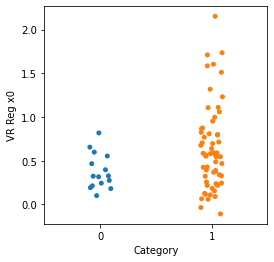

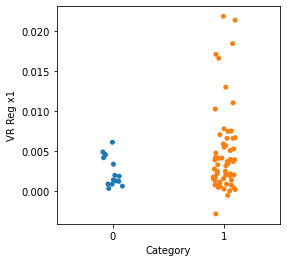

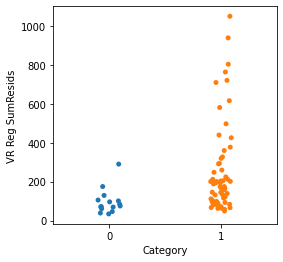

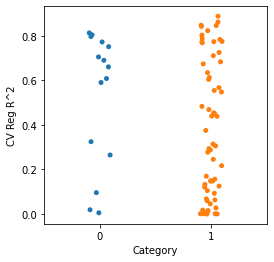

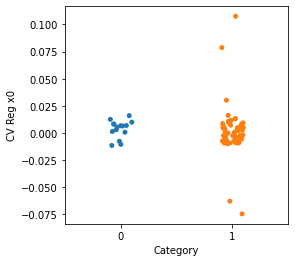

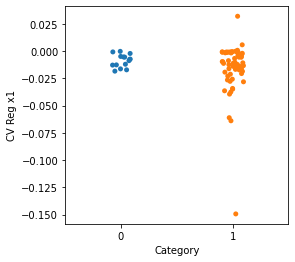

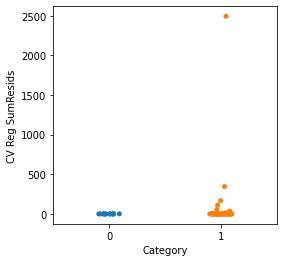

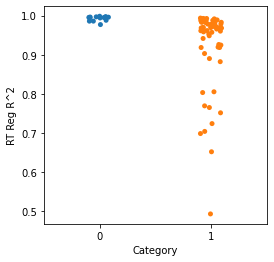

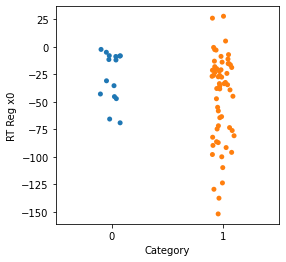

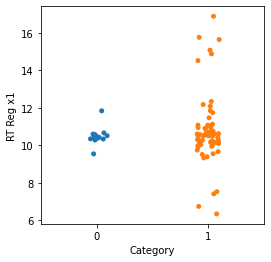

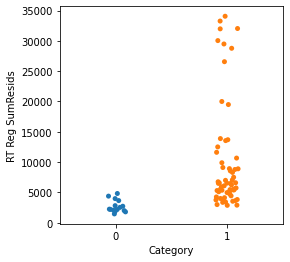

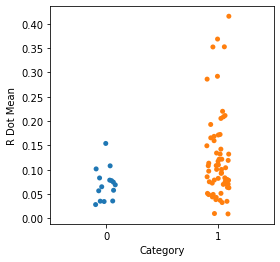

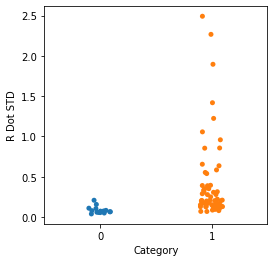

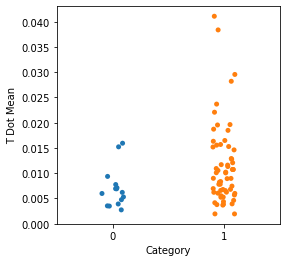

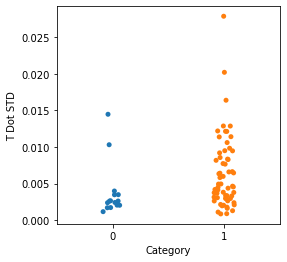

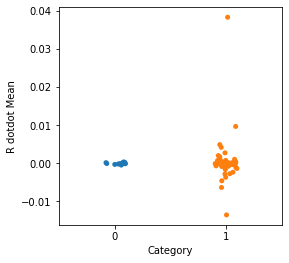

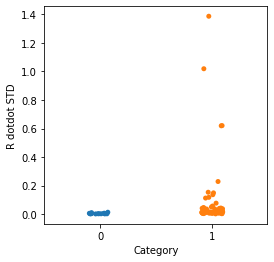

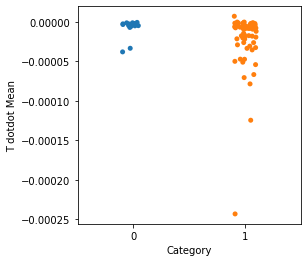

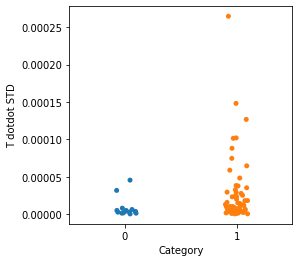

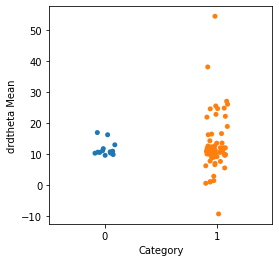

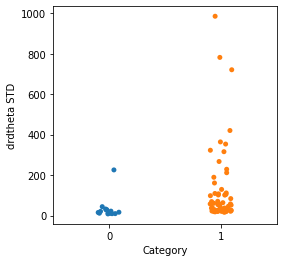

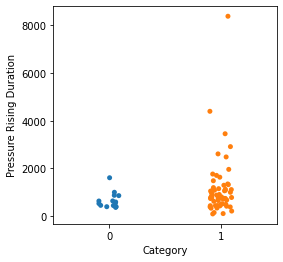

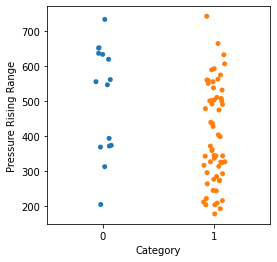

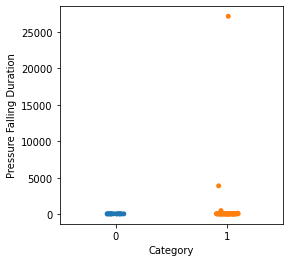

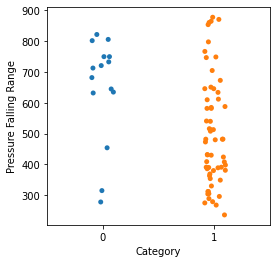

In [ ]:
for i in df_all_features_static[2:]: 
    plt.figure(figsize = (4, 4))
    #plt.title('Strip Plot of {} vs. Category (0 - Control; 1 - Patient)'.format(i), fontsize = 15)
    sns.stripplot(x = df_all_features_static['Category'], y = df_all_features_static[i])

In [ ]:
print(df_all_features_static['Category'])
print()

0     0
1     0
2     0
3     0
4     0
     ..
71    1
72    1
73    1
74    1
75    1
Name: Category, Length: 76, dtype: int64



/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 6.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 26.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 47.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn

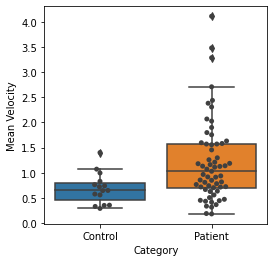

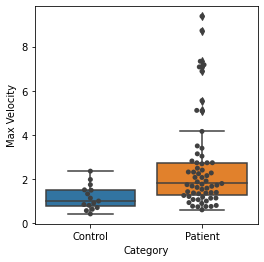

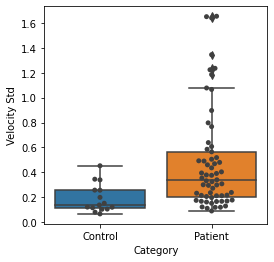

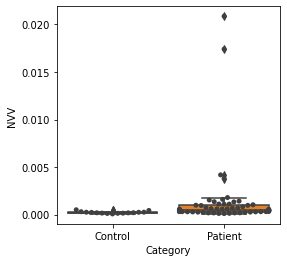

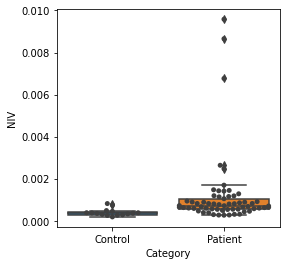

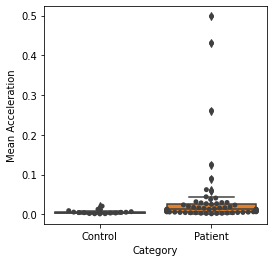

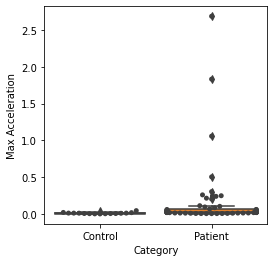

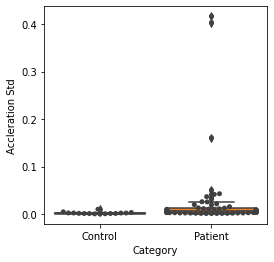

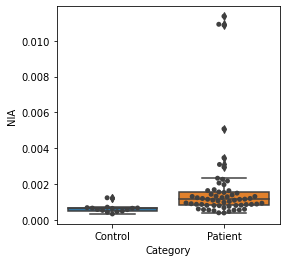

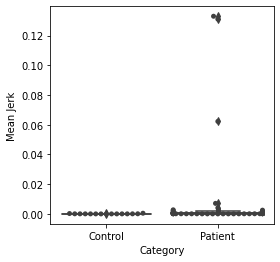

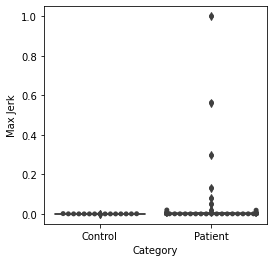

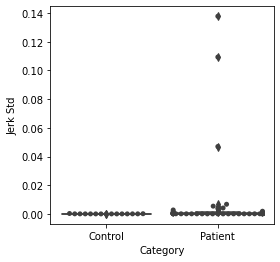

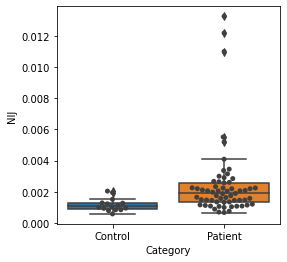

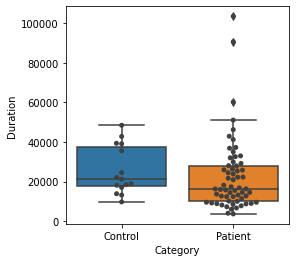

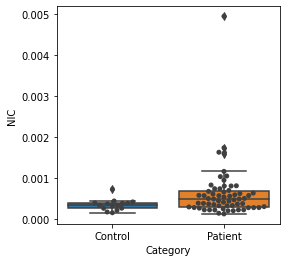

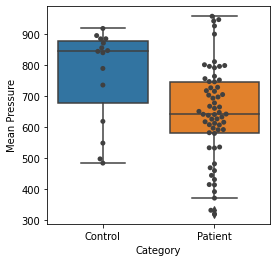

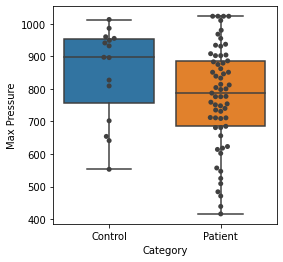

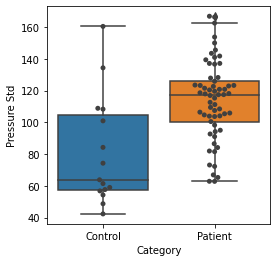

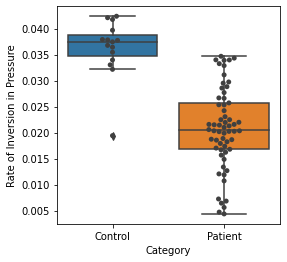

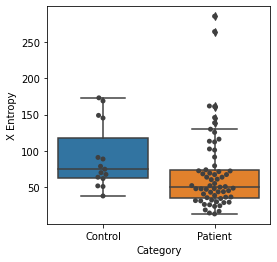

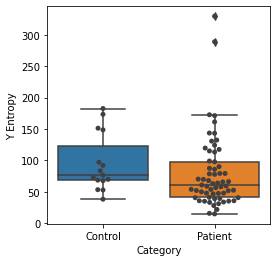

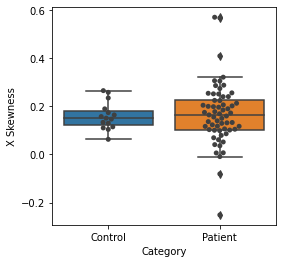

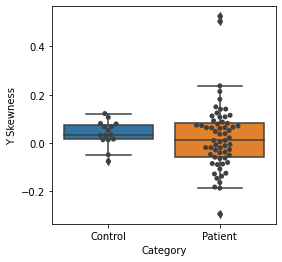

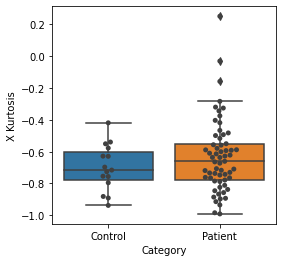

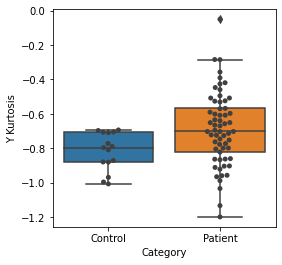

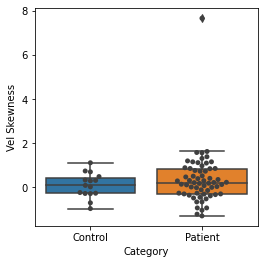

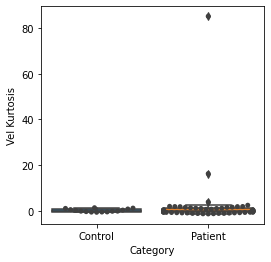

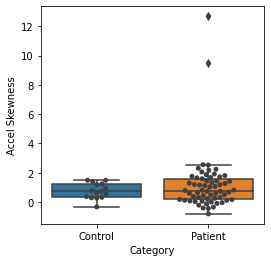

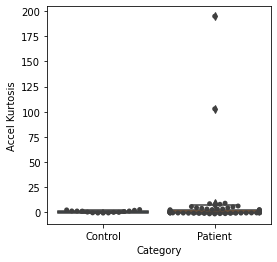

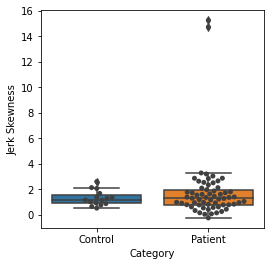

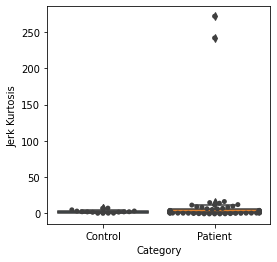

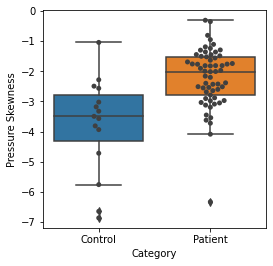

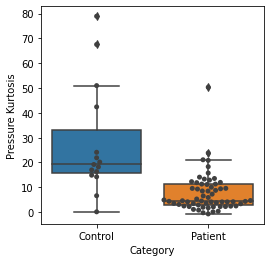

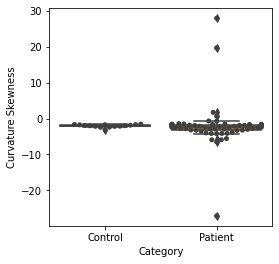

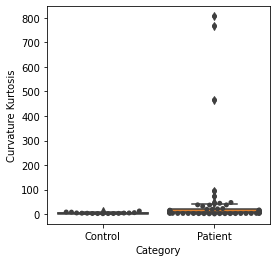

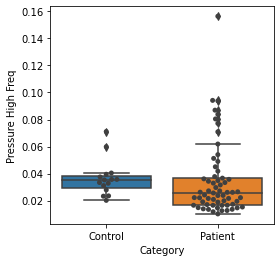

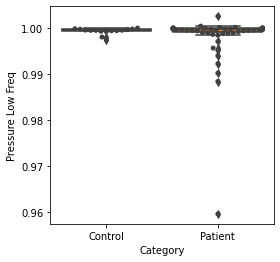

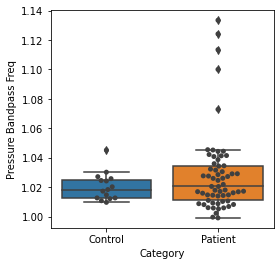

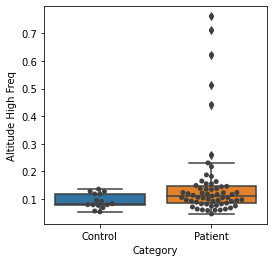

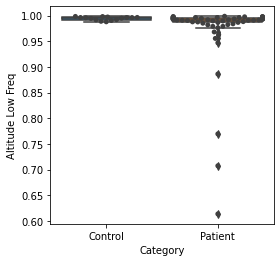

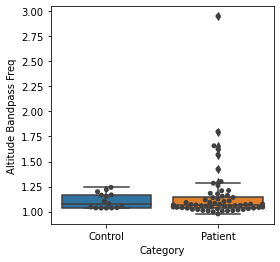

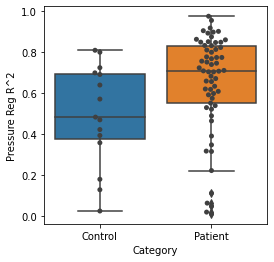

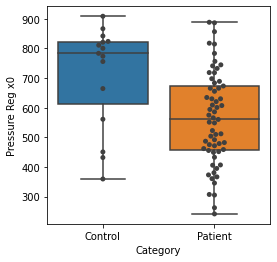

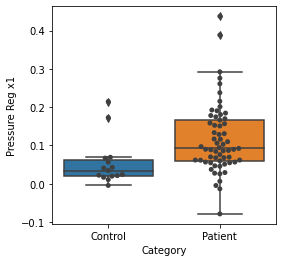

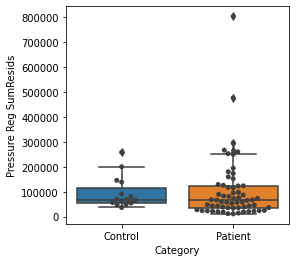

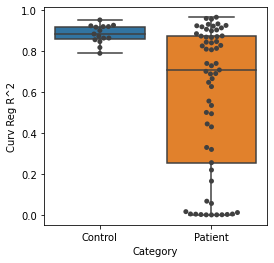

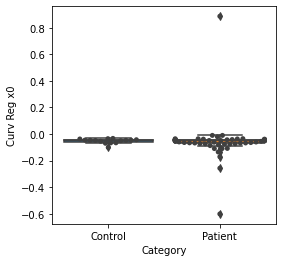

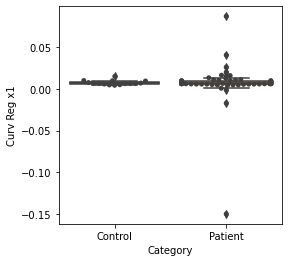

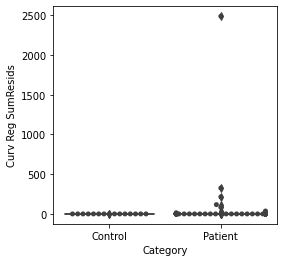

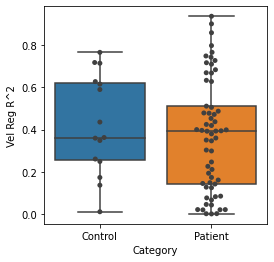

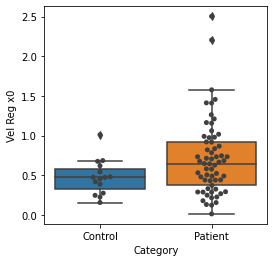

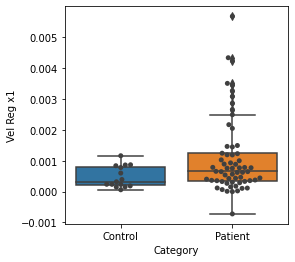

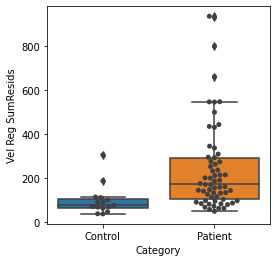

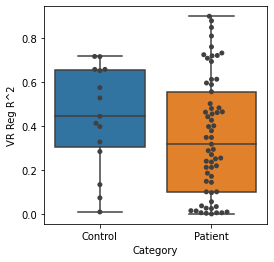

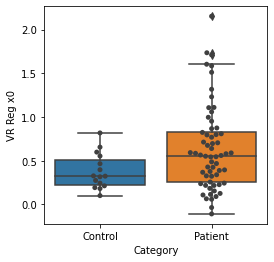

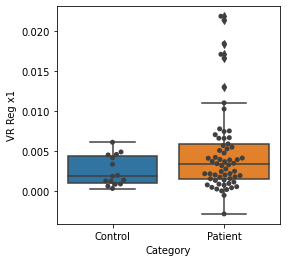

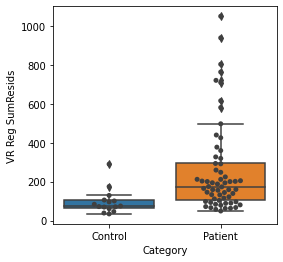

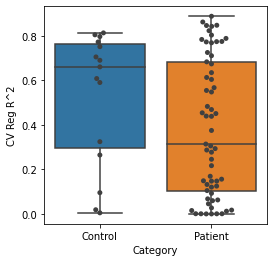

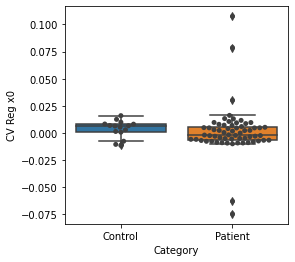

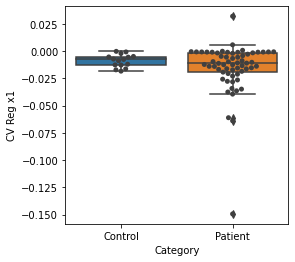

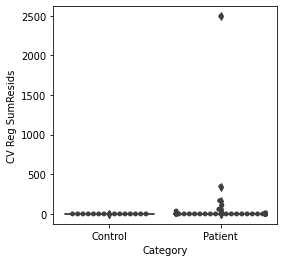

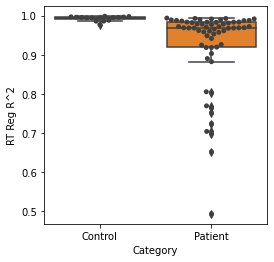

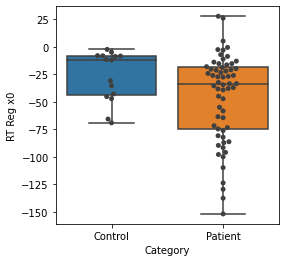

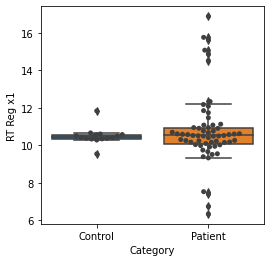

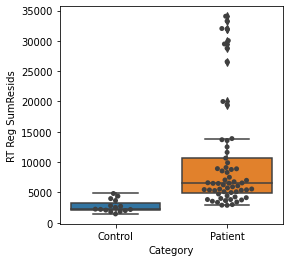

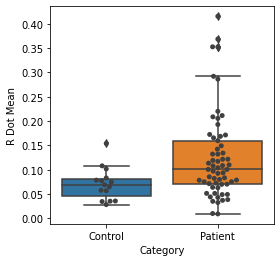

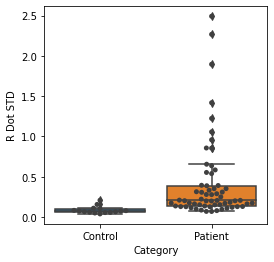

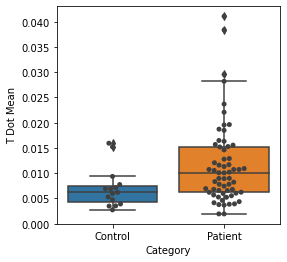

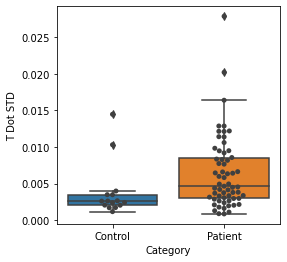

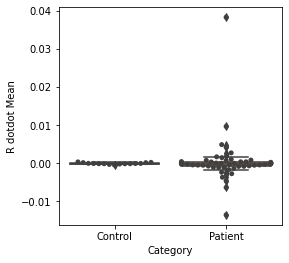

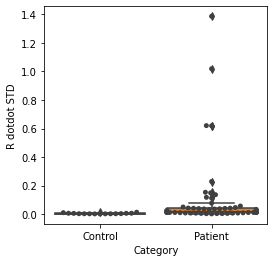

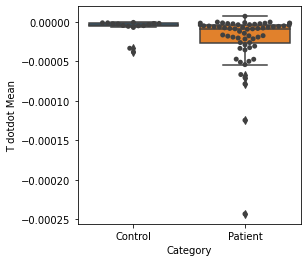

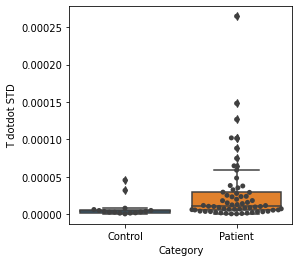

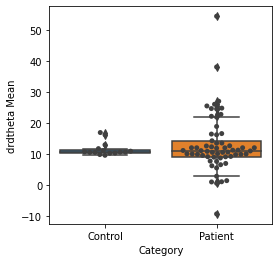

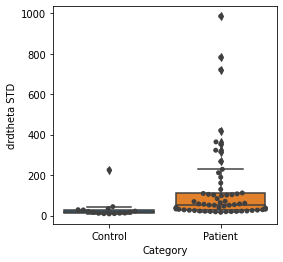

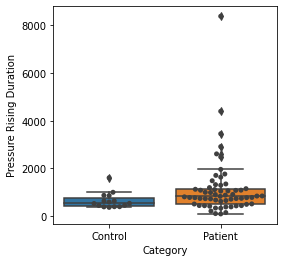

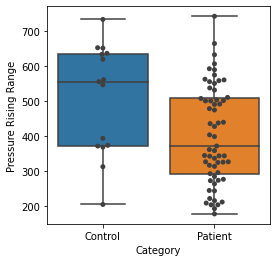

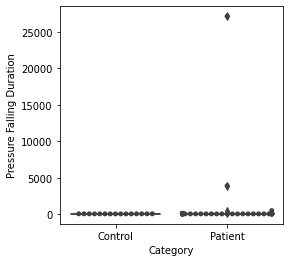

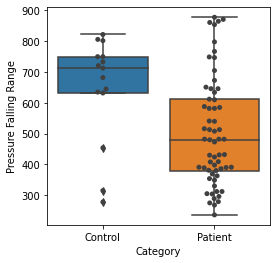

In [ ]:
#layer scatterplot on boxplot (static)

for i in df_all_features_static.columns[2:]: 
    plt.figure(figsize = (4, 4))
    sns.boxplot(x = df_all_features_static['Category'].replace(to_replace=[0,1], value=['Control', 'Patient']), y = df_all_features_static[i])
    sns.swarmplot(x = df_all_features_static['Category'].replace(to_replace=[0,1], value=['Control', 'Patient']), y = df_all_features_static[i], color=".25")

## Feature Selection

In [ ]:
# all data here is in /work/Static_HW_features.csv
df_all_features_static = pd.read_csv('/work/Static_HW_features.csv')
#df_all_features_static.dropna(axis='columns')
df_all_features_static

Static Subject ID  Category  Mean Velocity  Max Velocity  \
0        /work/ParkinsonHW/C_0001.txt         0       0.763353      1.508147   
1        /work/ParkinsonHW/C_0002.txt         0       0.559823      1.001812   
2        /work/ParkinsonHW/C_0003.txt         0       0.577474      0.808143   
3        /work/ParkinsonHW/C_0004.txt         0       0.645112      1.133661   
4        /work/ParkinsonHW/C_0005.txt         0       0.995901      1.976179   
..                                ...       ...            ...           ...   
71   /work/ParkinsonHW/P_26060007.txt         1       0.766646      2.073436   
72  /work/ParkinsonHW/H_P000-0035.txt         1       2.026080      9.373600   
73  /work/ParkinsonHW/H_p000-0018.txt         1       0.452617      0.801572   
74   /work/ParkinsonHW/P_23100002.txt         1       0.635284      1.069605   
75  /work/ParkinsonHW/H_P000-0032.txt         1       1.556340      2.273901   

    Velocity Std       NVV       NIV  Mean Acceleration  Max Acceleration  \
0       0.256847  0.000199  0.000386           0.005358          0.012816   
1       0.137363  0.000238  0.000285           0.003091          0.006730   
2       0.119065  0.000142  0.000253           0.002888          0.006152   
3       0.151134  0.000251  0.000330           0.004083          0.012296   
4       0.344574  0.000203  0.000360           0.009018          0.018844   
..           ...       ...       ...                ...               ...   
71      0.378668  0.000396  0.000642           0.006019          0.022859   
72      1.224294  0.017409  0.008655           0.431046          2.685503   
73      0.169099  0.000637  0.000719           0.003721          0.018696   
74      0.161262  0.000191  0.000274           0.003823          0.006819   
75      0.307547  0.000550  0.001445           0.023593          0.045754   

    Accleration Std  ...  R dotdot Mean  R dotdot STD  T dotdot Mean  \
0          0.002136  ...      -0.000290      0.003108      -0.000003   
1          0.001066  ...      -0.000100      0.002019      -0.000002   
2          0.001091  ...       0.000180      0.003554      -0.000003   
3          0.002318  ...      -0.000123      0.003338      -0.000005   
4          0.003200  ...      -0.000461      0.003006      -0.000006   
..              ...  ...            ...           ...            ...   
71         0.003773  ...      -0.000338      0.015033      -0.000002   
72         0.403142  ...      -0.013530      1.386249      -0.000033   
73         0.002739  ...      -0.000213      0.015425      -0.000003   
74         0.001408  ...       0.000037      0.004329      -0.000006   
75         0.009991  ...      -0.003651      0.043178      -0.000026   

    T dotdot STD  drdtheta Mean  drdtheta STD  Pressure Rising Duration  \
0       0.000004      10.610610      9.597464                       387   
1       0.000002      10.803881     11.155429                       387   
2       0.000003      11.830677     12.358261                       630   
3       0.000005      10.404557     15.273382                       626   
4       0.000006      10.601360      8.134354                       584   
..           ...            ...           ...                       ...   
71      0.000003      13.639552     35.132567                      4394   
72      0.000038      27.093770    322.825381                       614   
73      0.000004      18.972630     70.527852                       767   
74      0.000007      12.684681     32.778074                      1342   
75      0.000025       7.712653     37.284051                       324   

    Pressure Rising Range  Pressure Falling Duration  Pressure Falling Range  
0                     633                         50                     822  
1                     561                         43                     713  
2                     636                         54                     682  
3                     733                         42

In [ ]:
# all data here is from /work/Dynamic_HW_features.csv
df_all_features_dynamic = pd.read_csv('/work/Dynamic_HW_features.csv')
df_all_features_dynamic.dropna(inplace = True)
#df.reset_index(drop=True)

df_all_features_dynamic

dynamic Subject ID  Category  Mean Velocity  Max Velocity  \
0        /work/ParkinsonHW/C_0001.txt         0       0.608264      1.038402   
1        /work/ParkinsonHW/C_0002.txt         0       0.570309      0.929899   
2        /work/ParkinsonHW/C_0003.txt         0       0.525343      0.963414   
3        /work/ParkinsonHW/C_0004.txt         0       0.648046      1.335771   
4        /work/ParkinsonHW/C_0005.txt         0       0.891953      1.579599   
..                                ...       ...            ...           ...   
70  /work/ParkinsonHW/H_P000-0040.txt         1       3.414150      8.028899   
71   /work/ParkinsonHW/P_26060007.txt         1       0.698569      1.957498   
72  /work/ParkinsonHW/H_P000-0035.txt         1       2.212872     13.076952   
74   /work/ParkinsonHW/P_23100002.txt         1       1.079148      2.172759   
75  /work/ParkinsonHW/H_P000-0032.txt         1       0.874963      1.285325   

    Velocity Std       NVV       NIV  Mean Acceleration  Max Acceleration  \
0       0.129533  0.000166  0.000353           0.003417          0.006625   
1       0.104160  0.000194  0.000427           0.003099          0.005938   
2       0.139191  0.000195  0.000328           0.002700          0.008736   
3       0.222400  0.000331  0.000460           0.004301          0.010183   
4       0.270280  0.000199  0.000575           0.007222          0.015176   
..           ...       ...       ...                ...               ...   
70      1.756024  0.001808  0.002267           0.144575          0.376329   
71      0.437480  0.000442  0.000483           0.006214          0.026428   
72      1.779768  0.018579  0.009523           0.480414          3.842637   
74      0.384755  0.000287  0.000484           0.012620          0.029416   
75      0.231421  0.000541  0.000958           0.009464          0.022818   

    Accleration Std  ...  R dotdot Mean  R dotdot STD  T dotdot Mean  \
0          0.001501  ...      -0.000004      0.001645      -0.000004   
1          0.001374  ...       0.000046      0.002677      -0.000004   
2          0.001349  ...       0.000197      0.005942      -0.000002   
3          0.002125  ...       0.000157      0.004784      -0.000003   
4          0.002747  ...      -0.000651      0.006301      -0.000006   
..              ...  ...            ...           ...            ...   
70         0.072914  ...      -0.005992      0.162343      -0.000096   
71         0.004959  ...      -0.000098      0.009124      -0.000004   
72         0.510012  ...       0.007096      0.703655      -0.000010   
74         0.005136  ...      -0.000388      0.008315      -0.000005   
75         0.004842  ...      -0.001577      0.031355      -0.000019   

    T dotdot STD  drdtheta Mean  drdtheta STD  Pressure Rising Duration  \
0       0.000004      11.320021     14.241246                     704.0   
1       0.000004      11.196910     15.381997                     457.0   
2       0.000002      14.263745     28.395524                     702.0   
3       0.000004      11.241506     19.555250                     577.0   
4       0.000006      10.722401     15.824590                     506.0   
..           ...            ...           ...                       ...   
70      0.000124       1.658796    117.045618                     190.0   
71      0.000005      13.473992     38.764131                    1533.0   
72      0.000002       5.691661    146.272575                     433.0   
74      0.000006       6.480644     17.627607                    1153.0   
75      0.000022      10.335813    236.500556                     598.0   

    Pressure Rising Range  Pressure Falling Duration  Pressure Falling Range  
0                   680.0                       50.0                   724.0  
1                   675.0                       49.0                   722.0  
2                   581.0                       63.0                   736.0  
3                   708.0                       49.

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 12.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 50.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 28.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/shared-libs/python3.7/py/lib/python3.7/site-packages/seabor

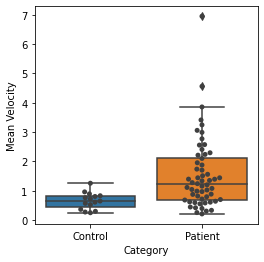

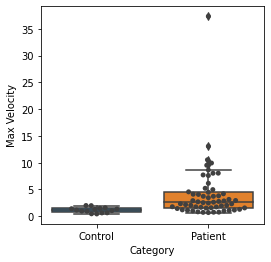

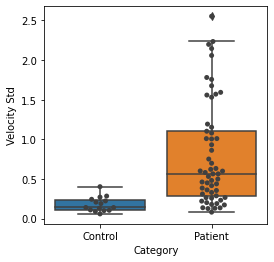

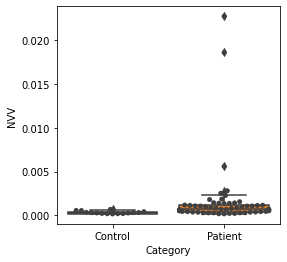

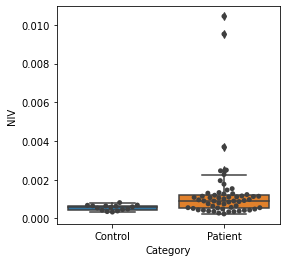

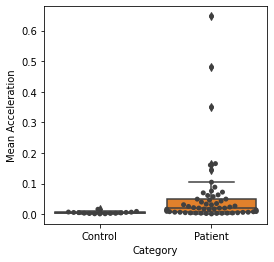

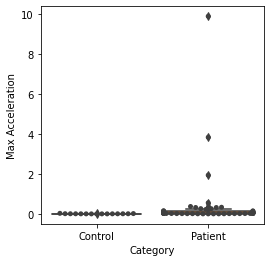

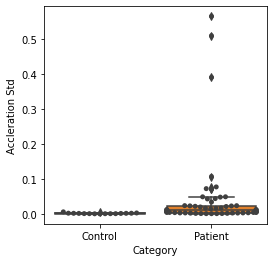

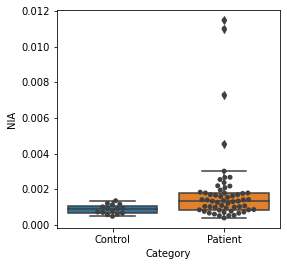

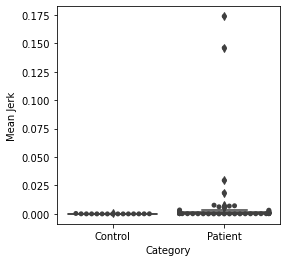

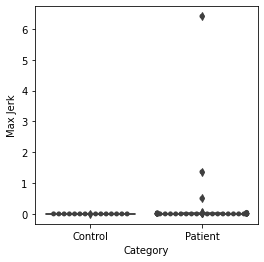

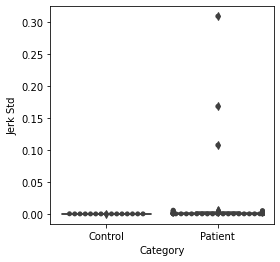

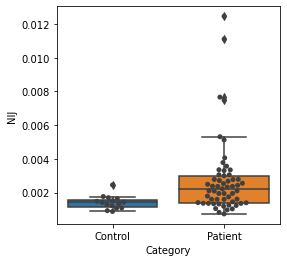

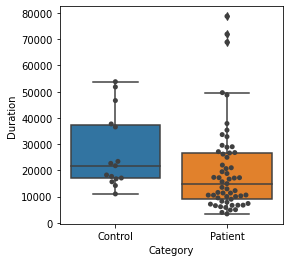

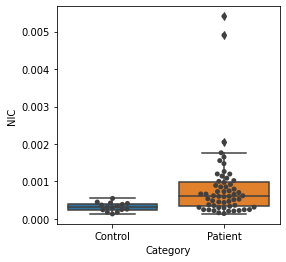

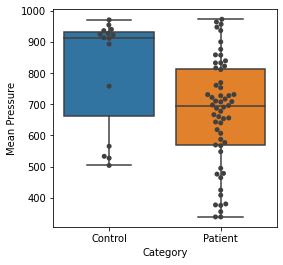

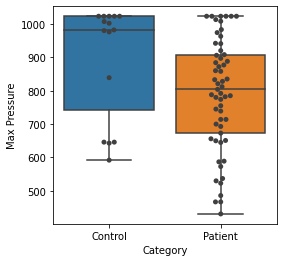

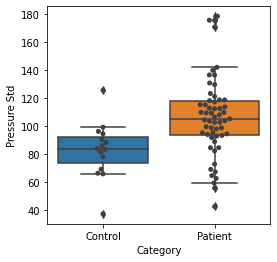

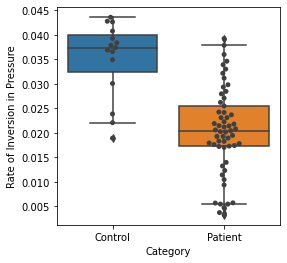

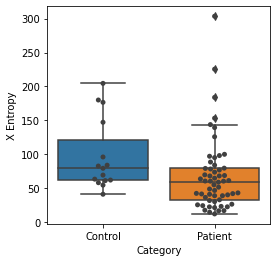

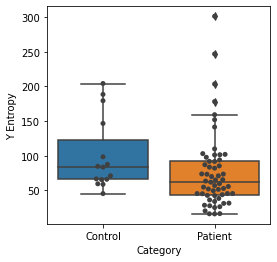

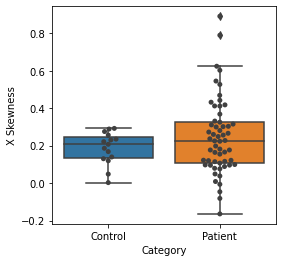

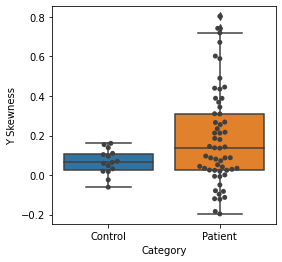

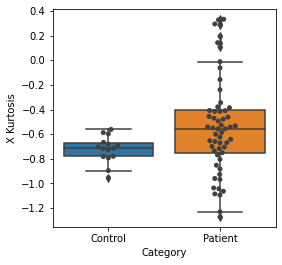

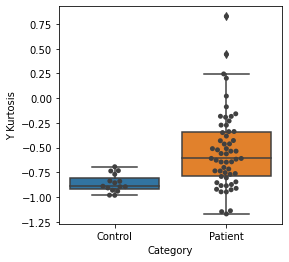

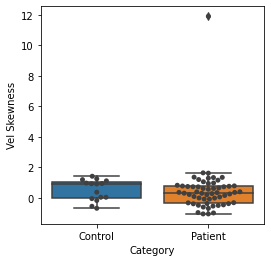

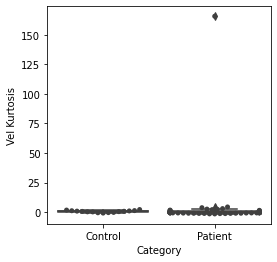

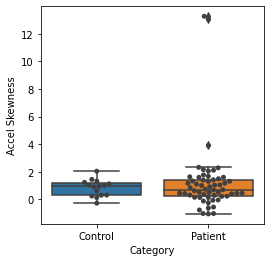

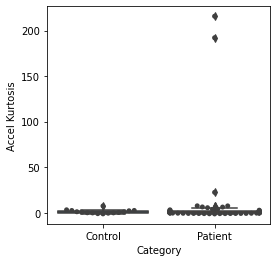

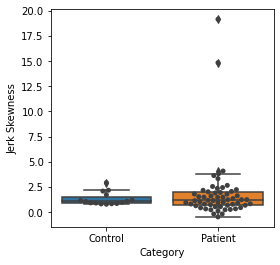

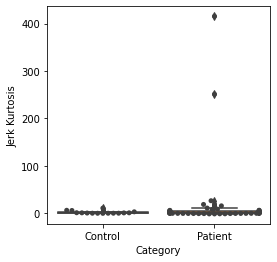

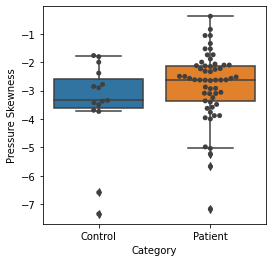

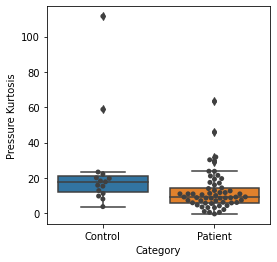

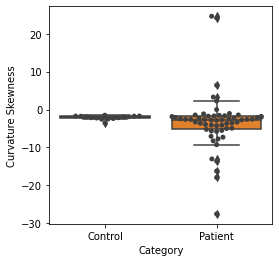

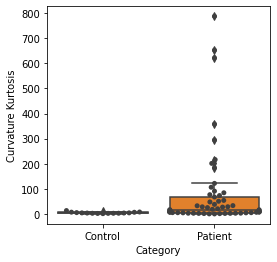

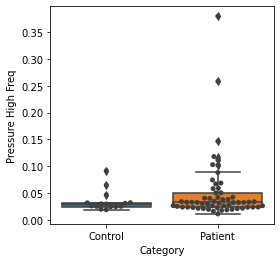

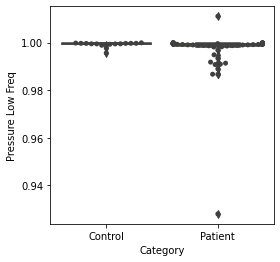

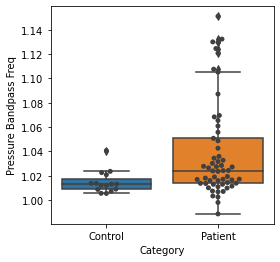

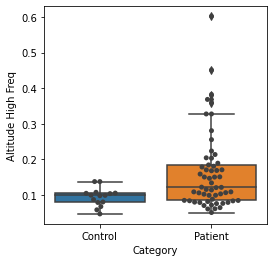

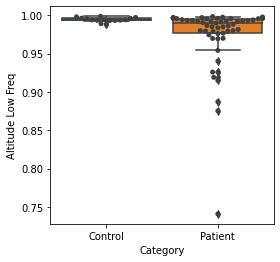

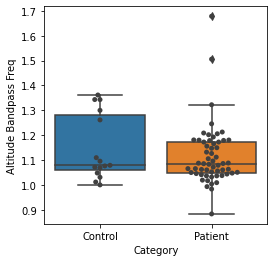

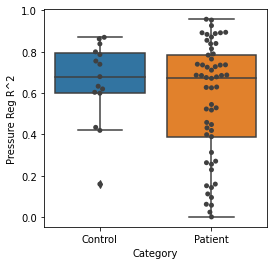

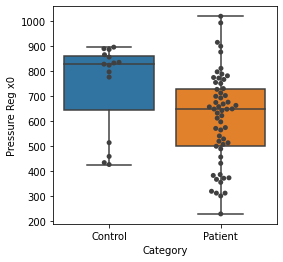

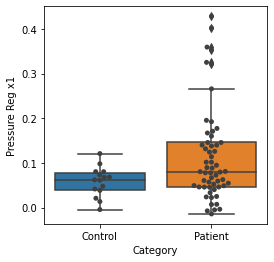

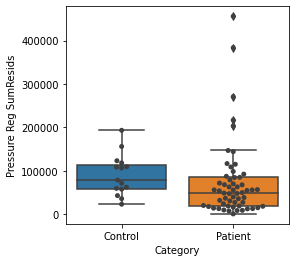

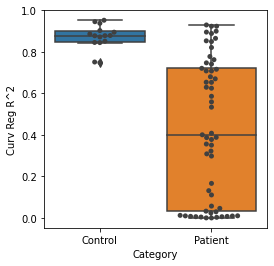

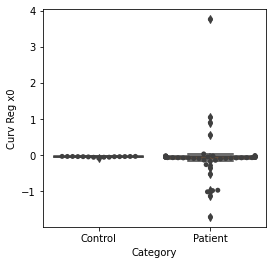

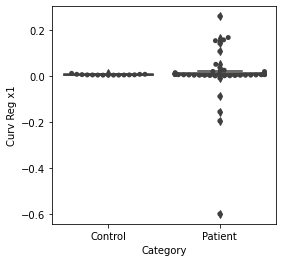

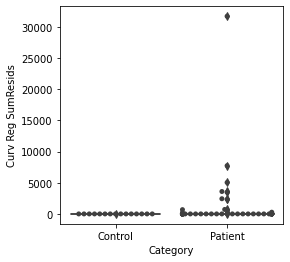

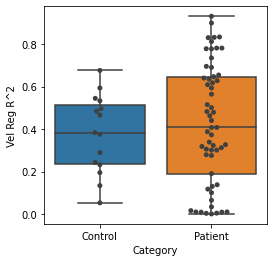

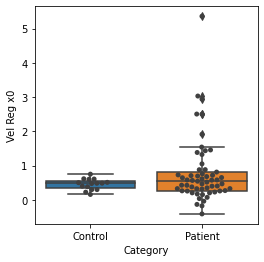

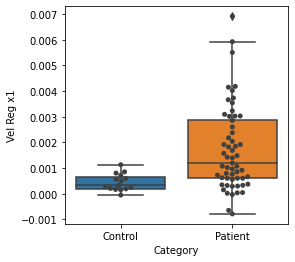

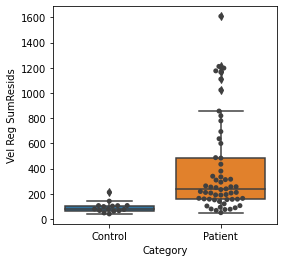

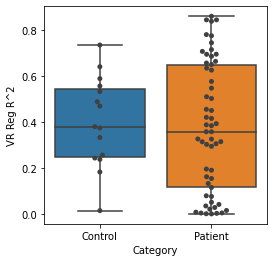

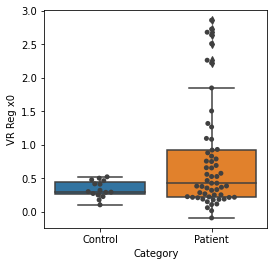

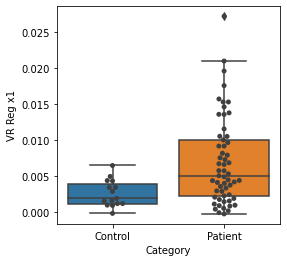

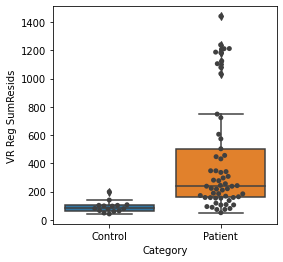

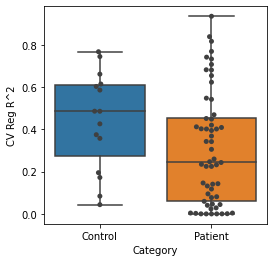

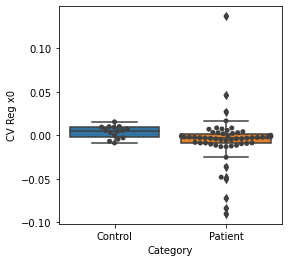

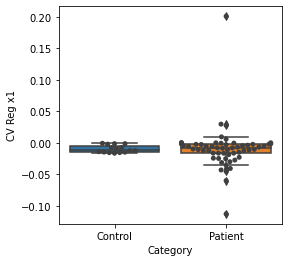

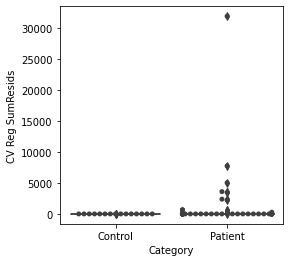

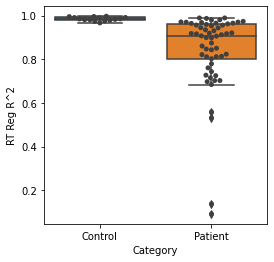

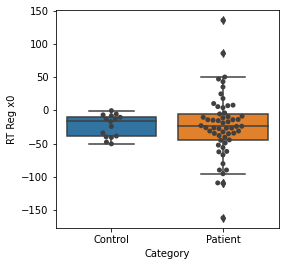

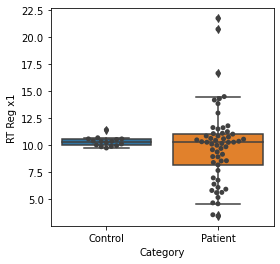

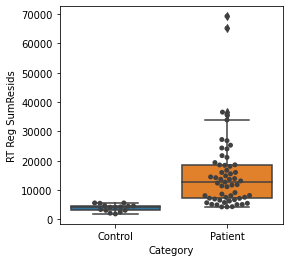

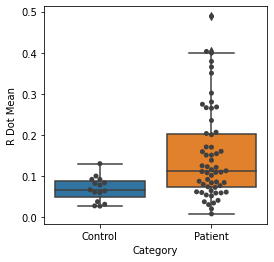

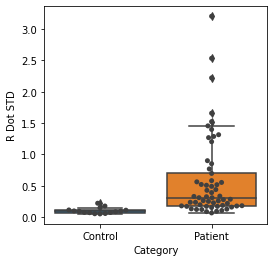

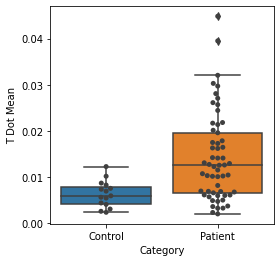

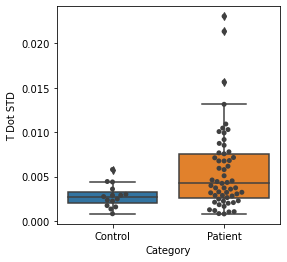

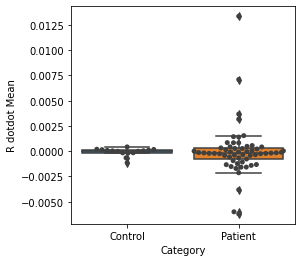

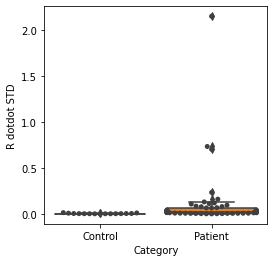

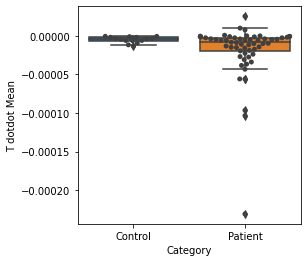

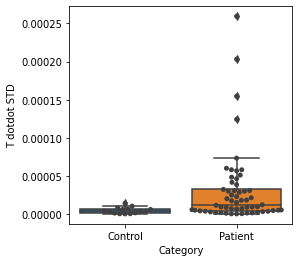

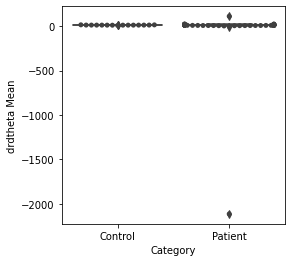

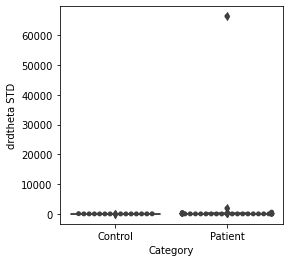

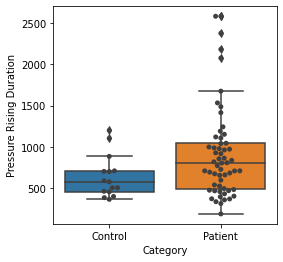

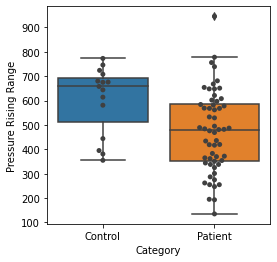

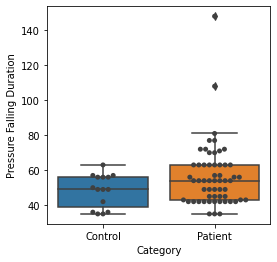

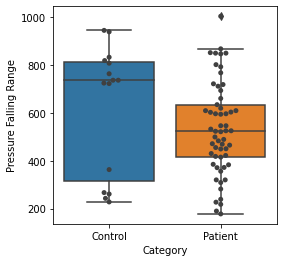

In [ ]:
#layer scatterplot on boxplot (dynamic)

for i in df_all_features_dynamic.columns[2:]: 
    plt.figure(figsize = (4, 4))
    sns.boxplot(x = df_all_features_dynamic['Category'].replace(to_replace=[0,1], value=['Control', 'Patient']), y = df_all_features_dynamic[i])
    sns.swarmplot(x = df_all_features_dynamic['Category'].replace(to_replace=[0,1], value=['Control', 'Patient']), y = df_all_features_dynamic[i], color=".25")

In [ ]:
# df_all_features_dynamic
# df_all_features_static
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feature_cols = df_all_features_static.columns[2:].values
Xcols = df_all_features_static.loc[:, feature_cols]
ycols = df_all_features_static.Category

'''
feature_cols = df_all_features_dynamic.columns[2:].values
Xcols = df_all_features_dynamic.loc[:, feature_cols]
ycols = df_all_features_dynamic.Category
'''

'\nfeature_cols = df_all_features_dynamic.columns[2:].values\nXcols = df_all_features_dynamic.loc[:, feature_cols]\nycols = df_all_features_dynamic.Category\n'

[0.01082993 0.01092279 0.01087451 0.00687645 0.01320117 0.00472748
 0.00947115 0.00996537 0.01804058 0.00815394 0.0077089  0.00967698
 0.01204565 0.00417678 0.00357149 0.01812314 0.00732712 0.03611849
 0.0872766  0.00789384 0.00701547 0.00635386 0.00888957 0.00572035
 0.00946673 0.00675314 0.00179113 0.00594594 0.00497204 0.00607463
 0.00377736 0.04014692 0.05511835 0.00504905 0.00533427 0.01107004
 0.00897357 0.00560857 0.00307597 0.0057046  0.00274686 0.01265742
 0.02492487 0.01624582 0.00606031 0.02377293 0.00495255 0.00391336
 0.0028809  0.00843603 0.00658197 0.00520963 0.01456573 0.00519939
 0.00436941 0.00560756 0.01440292 0.00643393 0.00495144 0.00269682
 0.00793975 0.02495993 0.02077382 0.00693142 0.05293198 0.00839135
 0.03258195 0.01186501 0.01292552 0.00723108 0.01500687 0.00791389
 0.00768255 0.01237435 0.02381877 0.01973775 0.01658598 0.0071975
 0.02271678]


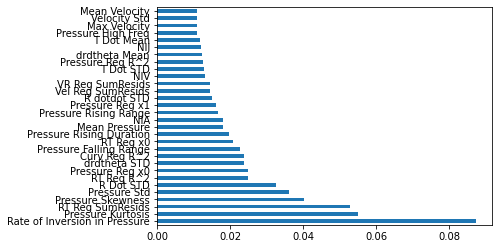

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(Xcols,ycols)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=Xcols.columns)
#print(feat_importances)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

## Logistic Regression

In [ ]:
# 1. import
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve

# 2. instantiate model

'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Reg x0', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']
# feature_cols = ['Rate of Inversion in Pressure', 'R Dot STD', 'RT Reg R^2', 'Curv Reg R^2']
feature_cols = ['RT Reg R^2', 'Rate of Inversion in Pressure']

X = df_all_features_static.loc[:, feature_cols].values
y = df_all_features_static.Category.values

model_log_aucs = []

for i in range((10)): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.8, random_state=i, stratify = y)

    logreg = LogisticRegression(solver='lbfgs', max_iter = 1200000)

    # 3. fit 
    logreg.fit(trainX, trainy)

    pred_class = logreg.predict(testX)
    pred_probs = logreg.predict_proba(testX)
    pred_probs = pred_probs[:, 1]

    # 4. calculate scores

    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_log_auc = roc_auc_score(testy, pred_probs)
    model_log_aucs.append(model_log_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('Logistic Regression ROC', fontsize = 17)

    # # show the legend
    # pyplot.legend()
    # # show the plot
    # pyplot.show()

In [ ]:
model_log_aucs = [1.0-x if x <0.5 else x for x in model_log_aucs]
print(model_log_aucs)
print(np.mean(model_log_auc))

[0.9591836734693878, 0.9608843537414966, 0.9710884353741497, 0.9761904761904763, 0.9489795918367347, 0.9506802721088436, 0.9795918367346939, 0.9438775510204083, 0.9506802721088435, 0.9506802721088435]
0.9506802721088435


### SVM

In [ ]:
from sklearn.svm import SVC

'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Reg x0', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']
# feature_cols = ['Rate of Inversion in Pressure', 'R Dot STD', 'RT Reg R^2', 'Curv Reg R^2']
feature_cols = ['RT Reg R^2', 'Rate of Inversion in Pressure']

X = df_all_features_static.loc[:, feature_cols].values
y = df_all_features_static.Category.values

model_svm_aucs = []
for i in range(50): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=i, stratify = y)

    svclassifier = SVC(kernel='rbf', probability = True)

    svclassifier.fit(trainX, trainy)

    pred_class = svclassifier.predict(testX)
    pred_probs = svclassifier.predict_proba(testX)
    pred_probs = pred_probs[:, 1]


    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_svm_auc = roc_auc_score(testy, pred_probs)
    model_svm_aucs.append(model_svm_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('SVM', fontsize = 17)

    # # show the legend
    # pyplot.legend()

    # # show the plot
    # pyplot.show()

In [ ]:
model_svm_aucs = [1.0-x if x <0.5 else x for x in model_svm_aucs]

print(model_svm_aucs)
print(np.mean(model_svm_aucs))

[1.0, 0.9907834101382489, 0.9583333333333334, 0.9958333333333333, 0.975, 0.9815668202764978, 1.0, 1.0, 1.0, 0.9958333333333333, 1.0, 0.9861751152073733, 0.9769585253456222, 0.9833333333333334, 1.0, 0.9875, 0.9907834101382489, 1.0, 0.9875, 0.9815668202764977, 0.9815668202764978, 0.967741935483871, 0.9815668202764978, 0.9907834101382489, 0.9958333333333333, 0.975, 0.9631336405529954, 0.9631336405529954, 1.0, 0.9769585253456222, 0.9907834101382489, 0.9708333333333333, 1.0, 0.9833333333333334, 0.9953917050691244, 1.0, 0.9723502304147466, 0.9861751152073733, 0.9815668202764978, 0.9723502304147466, 0.9833333333333334, 0.9708333333333333, 0.9666666666666667, 1.0, 0.9833333333333334, 0.9953917050691244, 0.9723502304147466, 1.0, 1.0, 0.9958333333333333]
0.9861482334869431


In [ ]:
# Dynamic
'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Reg x0', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']
# feature_cols = ['Rate of Inversion in Pressure', 'R Dot STD', 'RT Reg R^2', 'Curv Reg R^2']
feature_cols = ['RT Reg R^2', 'Rate of Inversion in Pressure']

X = df_all_features_dynamic.loc[:, feature_cols].values
y = df_all_features_dynamic.Category.values

model_svm_aucs = []
for i in range(50): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=i, stratify = y)

    svclassifier = SVC(kernel='rbf', probability = True)

    svclassifier.fit(trainX, trainy)

    pred_class = svclassifier.predict(testX)
    pred_probs = svclassifier.predict_proba(testX)
    pred_probs = pred_probs[:, 1]


    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_svm_auc = roc_auc_score(testy, pred_probs)
    model_svm_aucs.append(model_svm_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('SVM', fontsize = 17)

    # # show the legend
    # pyplot.legend()

    # # show the plot
    # pyplot.show()

In [ ]:
model_svm_aucs = [1.0-x if x <0.5 else x for x in model_svm_aucs]

print(model_svm_aucs)
print(np.mean(model_svm_aucs))

[1.0, 0.9704433497536946, 0.9776785714285714, 0.9866071428571428, 0.9508928571428572, 1.0, 0.9866071428571428, 0.9852216748768473, 0.9852216748768472, 0.9955357142857143, 1.0, 0.9852216748768473, 0.9901477832512315, 0.96875, 0.9901477832512315, 0.96875, 0.9901477832512315, 0.9950738916256158, 0.9776785714285714, 0.9753694581280788, 0.9704433497536946, 0.9950738916256159, 0.9901477832512315, 0.9852216748768472, 1.0, 0.9732142857142857, 0.9901477832512315, 0.9852216748768472, 0.9753694581280787, 0.9950738916256159, 0.9950738916256159, 1.0, 0.9852216748768472, 0.9732142857142857, 0.9556650246305418, 0.9852216748768473, 0.9753694581280787, 0.9802955665024631, 0.9802955665024631, 0.9901477832512315, 0.9598214285714286, 1.0, 0.9598214285714286, 1.0, 0.9776785714285714, 0.9852216748768473, 0.9901477832512315, 0.980295566502463, 0.9776785714285714, 0.9866071428571428]
0.9835437192118226


## Random Forest

In [ ]:
feature_cols = df_all_features_static.columns[2:].values[:5]
print(len(feature_cols))
feature_cols_subset = feature_cols[:5]
feature_subset = []
for i in range(len(feature_cols_subset)):
    for j in range(i+1,len(feature_cols_subset)):
        feature_subset.append(feature_cols_subset[i])
        feature_subset.append(feature_cols_subset[j])
        print(feature_subset)
        feature_subset = []
#print(feature_cols_subset)

feature_cols = ['VR Reg SumResids']
X = df_all_features_static.loc[:, feature_cols].values
y = df_all_features_static.Category.values
print(X)


5
['Mean Velocity', 'Max Velocity']
['Mean Velocity', 'Velocity Std']
['Mean Velocity', 'NVV']
['Mean Velocity', 'NIV']
['Max Velocity', 'Velocity Std']
['Max Velocity', 'NVV']
['Max Velocity', 'NIV']
['Velocity Std', 'NVV']
['Velocity Std', 'NIV']
['NVV', 'NIV']
[[  95.74171196]
 [  74.60637706]
 [  69.12862008]
 [ 100.65792938]
 [ 128.89034992]
 [  83.49204246]
 [ 105.2138794 ]
 [  38.45023418]
 [  33.87607545]
 [  71.60767914]
 [  45.93381201]
 [  60.66431249]
 [ 290.03913658]
 [ 174.65699467]
 [  70.42285656]
 [  88.1473123 ]
 [ 145.49306857]
 [  62.10465508]
 [ 158.71293515]
 [ 155.6665677 ]
 [ 121.94873381]
 [ 224.21584782]
 [ 425.57978392]
 [ 131.68846877]
 [ 202.8078114 ]
 [  92.78986599]
 [ 439.54084815]
 [ 359.79310332]
 [ 939.36072198]
 [ 327.06367568]
 [ 291.50131606]
 [  71.50947617]
 [ 259.2658168 ]
 [ 194.06454579]
 [ 133.12749263]
 [ 319.39659907]
 [ 204.68971029]
 [ 174.63404437]
 [ 143.97616638]
 [ 158.61909985]
 [ 720.81611038]
 [ 616.04460566]
 [ 165.15322694]
 [ 18

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
import time

# Static
'''List of different feature sets to use: '''
feature_cols_all = df_all_features_dynamic.columns[2:].values
tInit = time.clock()
feature_cols = []
model_rf_aucs_all = []
model_rf_aucs_all_means = []
feature_cols_random_set = []

for m in range(len(feature_cols_all)):
    for n in range(m+1,len(feature_cols_all)):
        feature_cols.append(feature_cols_all[m])
        feature_cols.append(feature_cols_all[n])
        feature_cols_random_set.append(feature_cols)

        X = df_all_features_dynamic.loc[:, feature_cols].values
        y = df_all_features_dynamic.Category.values

        model_rf_aucs = []
        for i in range(5): 
            trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=i, stratify = y)

            # Instantiate model with 100 decision trees
            rf = RandomForestClassifier(n_estimators = 100, random_state = i)
            # Train the model on training data
            rf.fit(trainX, trainy);

            pred_class = rf.predict(testX)
            pred_probs = rf.predict_proba(testX)
            pred_probs = pred_probs[:, 1]


            # generate a no skill prediction (majority class)
            random_probs = [1 for _ in range(len(testy))]

            random_auc = roc_auc_score(testy, random_probs)
            model_rf_auc = roc_auc_score(testy, pred_probs)
            model_rf_aucs.append(model_rf_auc)

            # calculate roc curves
            ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
            lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

        feature_cols = []
        model_rf_aucs_all.append(model_rf_aucs)
        model_rf_aucs_all_means.append(np.mean(model_rf_aucs))
tElapsed = time.clock() - tInit

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('SVM', fontsize = 17)

    # # show the legend
    # pyplot.legend()

    # # show the plot
    # pyplot.show()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
indices = []
model_rf_aucs_all_means_sorted = np.sort(model_rf_aucs_all_means)
for i in range(len(model_rf_aucs_all_means_sorted[-100:])):
    indices.append(model_rf_aucs_all_means.index(model_rf_aucs_all_means_sorted[len(model_rf_aucs_all_means_sorted) - i - 1]))
print(indices)
for i in indices:
    print(feature_cols_random_set[i])
#print(model_rf_aucs_all.index())

print(model_rf_aucs_all_means_sorted[-100:])

print(len(feature_cols_random_set)) #79 choose 2
print(tElapsed)

[2631, 2913, 2628, 1296, 2910, 772, 742, 2538, 769, 1578, 1293, 2601, 2570, 1581, 770, 2567, 1635, 2835, 771, 2535, 2598, 1280, 1688, 788, 124, 2163, 785, 784, 2633, 563, 2980, 855, 809, 2076, 838, 837, 2120, 839, 464, 1113, 720, 1298, 2325, 491, 365, 564, 1632, 2286, 562, 2530, 1175, 2741, 737, 2892, 2715, 1562, 2961, 2400, 216, 535, 2832, 2522, 581, 565, 2943, 1277, 2876, 510, 1310, 2637, 852, 2640, 2895, 2616, 2073, 1302, 836, 2322, 507, 2930, 2562, 778, 778, 2283, 213, 983, 2623, 140, 2988, 801, 2526, 200, 200, 153, 1110, 2738, 787, 1565, 2540, 578]
['Curv Reg SumResids', 'RT Reg SumResids']
['CV Reg SumResids', 'RT Reg SumResids']
['Curv Reg SumResids', 'RT Reg R^2']
['Rate of Inversion in Pressure', 'RT Reg SumResids']
['CV Reg SumResids', 'RT Reg R^2']
['Max Jerk', 'Curv Reg SumResids']
['Max Jerk', 'Rate of Inversion in Pressure']
['Curv Reg R^2', 'RT Reg SumResids']
['Max Jerk', 'Curv Reg R^2']
['X Kurtosis', 'RT Reg R^2']
['Rate of Inversion in Pressure', 'RT Reg R^2']
['Curv

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Static
'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Reg x0', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# Top Polar
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']
# Top Regression Features
# feature_cols = ['RT Reg SumResids', 'RT Reg R^2', 'Vel Reg SumResids', 'VR Reg SumResids']
# # Top p-value
# feature_cols = ['Rate of Inversion in Pressure', 'RT Reg SumResids', 'RT Reg R^2', 'R Dot STD', 'Max Jerk', 'Jerk Std', 'Curv Reg SumResids']
# # Top AUC
# feature_cols = ['RT Reg SumResids', 'RT Reg R^2', 'R Dot STD', 'Max Jerk', 'Jerk Std', 'Curv Reg SumResids', 'Accleration Std']
feature_cols = ['Curv Reg SumResids']

X = df_all_features_static.loc[:, feature_cols].values
y = df_all_features_static.Category.values


model_rf_aucs = []
for i in range(50): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=i, stratify = y)

    # Instantiate model with 100 decision trees
    rf = RandomForestClassifier(n_estimators = 100, random_state = i)
    # Train the model on training data
    rf.fit(trainX, trainy);

    pred_class = rf.predict(testX)
    pred_probs = rf.predict_proba(testX)
    pred_probs = pred_probs[:, 1]


    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_rf_auc = roc_auc_score(testy, pred_probs)
    model_rf_aucs.append(model_rf_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('SVM', fontsize = 17)

    # # show the legend
    # pyplot.legend()

    # # show the plot
    # pyplot.show()

In [ ]:
model_rf_aucs = [1.0-x if x <0.5 else x for x in model_rf_aucs]

print(model_rf_aucs)
print(np.mean(model_rf_aucs))

[0.6916666666666665, 0.7327188940092165, 0.6833333333333332, 0.6020833333333333, 0.8041666666666667, 0.5944700460829493, 0.6854166666666667, 0.652073732718894, 0.8041474654377879, 0.5729166666666666, 0.5184331797235022, 0.7119815668202765, 0.695852534562212, 0.6520833333333333, 0.6612903225806451, 0.5541666666666667, 0.6059907834101382, 0.5875576036866359, 0.7375, 0.748847926267281, 0.5599078341013825, 0.5230414746543779, 0.6589861751152073, 0.6682027649769585, 0.6354166666666667, 0.5375, 0.6935483870967742, 0.6751152073732719, 0.6336405529953917, 0.5414746543778801, 0.7857142857142857, 0.7354166666666668, 0.5668202764976957, 0.8270833333333334, 0.532258064516129, 0.6267281105990783, 0.7073732718894009, 0.6382488479262673, 0.8018433179723503, 0.6728110599078341, 0.8333333333333333, 0.725, 0.6416666666666666, 0.6187499999999999, 0.61875, 0.7764976958525345, 0.5875576036866359, 0.6751152073732718, 0.7645833333333334, 0.7375]
0.6659316436251919


## Dynamic

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Dynamic
'''List of different feature sets to use: '''
# feature_cols = df_all_features_static.columns[2:].values
# feature_cols = ['Rate of Inversion in Pressure', 'Pressure Reg x0', 'Pressure Kurtosis', 'Pressure Skewness', 'Pressure Std']
# feature_cols = ['RT Reg SumResids', 'Pressure Reg x1', 'Curv Reg R^2', 'Pressure Reg x0', 'VR Reg SumResids', 'RT Reg R^2']
# Top Polar
# feature_cols = ['RT Reg SumResids', 'R Dot STD', 'RT Reg R^2', 'R dotdot STD', 'T Dot STD', 'drdtheta STD']
# Top Regression Features
# feature_cols = ['RT Reg SumResids', 'RT Reg R^2', 'Vel Reg SumResids', 'VR Reg SumResids']
# # Top p-value
# feature_cols = ['Rate of Inversion in Pressure', 'RT Reg SumResids', 'RT Reg R^2', 'R Dot STD', 'Max Jerk', 'Jerk Std', 'Curv Reg SumResids']
# # Top AUC
# feature_cols = ['RT Reg SumResids', 'RT Reg R^2', 'R Dot STD', 'Max Jerk', 'Jerk Std', 'Curv Reg SumResids', 'Accleration Std']
feature_cols = ['RT Reg SumResids', 'Rate of Inversion in Pressure']
X = df_all_features_dynamic.loc[:, feature_cols].values
y = df_all_features_dynamic.Category.values

model_rf_aucs = []
for i in range(50): 
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=i, stratify = y)

    # Instantiate model with 100 decision trees
    rf = RandomForestClassifier(n_estimators = 100, random_state = i)
    # Train the model on training data
    rf.fit(trainX, trainy);

    pred_class = rf.predict(testX)
    pred_probs = rf.predict_proba(testX)
    pred_probs = pred_probs[:, 1]


    # generate a no skill prediction (majority class)
    random_probs = [1 for _ in range(len(testy))]

    random_auc = roc_auc_score(testy, random_probs)
    model_rf_auc = roc_auc_score(testy, pred_probs)
    model_rf_aucs.append(model_rf_auc)

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, random_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, pred_probs)

    # plot the roc curve for the model
    # pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    # pyplot.plot(lr_fpr, lr_tpr, marker='.', label='SVM')

    # # axis labels
    # pyplot.xlabel('False Positive Rate', fontsize = 13)
    # pyplot.ylabel('True Positive Rate', fontsize = 13)
    # pyplot.title('SVM', fontsize = 17)

    # # show the legend
    # pyplot.legend()

    # # show the plot
    # pyplot.show()

In [ ]:
model_rf_aucs = [1.0-x if x <0.5 else x for x in model_rf_aucs]

print(model_rf_aucs)
print(np.mean(model_rf_aucs))

[0.9821428571428572, 0.9901477832512315, 0.9977678571428572, 0.9955357142857143, 0.9330357142857143, 1.0, 0.9910714285714286, 0.980295566502463, 0.9753694581280788, 0.9955357142857143, 0.9901477832512315, 0.9679802955665024, 0.9507389162561576, 0.9754464285714286, 0.9926108374384237, 0.9464285714285714, 0.9852216748768472, 0.9704433497536946, 0.9732142857142857, 0.9261083743842364, 0.9778325123152709, 0.9704433497536945, 0.9926108374384237, 0.9901477832512315, 0.9866071428571428, 0.9330357142857143, 0.9261083743842363, 1.0, 0.9679802955665023, 0.9975369458128078, 0.9605911330049262, 0.9955357142857143, 0.9310344827586207, 1.0, 0.960591133004926, 0.9802955665024631, 0.9926108374384237, 0.9753694581280787, 0.9655172413793104, 0.9704433497536946, 0.9642857142857143, 0.9910714285714286, 0.9285714285714286, 1.0, 0.9732142857142857, 1.0, 0.9556650246305418, 0.9901477832512315, 0.9866071428571428, 0.9732142857142857]
0.9751262315270935


In [ ]:
def fast_auc (x, y):
    rank_value = x.rank(method = 'average')
    n_pos = sum(y == 1)
    rank_sum = sum(rank_value[y == 1])
    u_value = rank_sum - (n_pos * (n_pos + 1)) / 2
    auc = u_value / (n_pos * (len(x) - n_pos))
    if auc >= 0.50:
        return auc 
    else:
        return 1.0 - auc 

In [ ]:
from scipy.stats import mannwhitneyu
from sklearn.metrics import auc

dfDynamicControls = df_all_features_dynamic[df_all_features_dynamic['Category'] == 0]
dfDynamicPatient = df_all_features_dynamic[df_all_features_dynamic['Category'] == 1]

dfStaticControls = df_all_features_static[df_all_features_static['Category'] == 0]
dfStaticPatient = df_all_features_static[df_all_features_static['Category'] == 1]

PValArrDynamic = []
MWUStatArrDynamic = []
aucDynamic = []

PValArrStatic = []
MWUStatArrStatic = []
aucStatic = []

for j, i in enumerate(df_all_features_dynamic.columns[2:]): 
    MWUStatArrDynamic.append(mannwhitneyu(dfDynamicControls[i], dfDynamicPatient[i], alternative = 'two-sided')[0])
    PValArrDynamic.append(mannwhitneyu(dfDynamicControls[i], dfDynamicPatient[i], alternative = 'two-sided')[1])
    aucDynamic.append(fast_auc(df_all_features_dynamic.iloc[:, j+2], df_all_features_dynamic.iloc[:, 1]))


for j, i in enumerate(df_all_features_static.columns[2:]): 
    MWUStatArrStatic.append(mannwhitneyu(dfStaticControls[i], dfStaticPatient[i], alternative = 'two-sided')[0])
    PValArrStatic.append(mannwhitneyu(dfStaticControls[i], dfStaticPatient[i], alternative = 'two-sided')[1])
    aucStatic.append(fast_auc(df_all_features_static.iloc[:, j + 2], df_all_features_static.iloc[:, 1]))

#for i in dfDynamicPatient.columns[2:]:

#print(sum(df_all_features_dynamic['Category'] == 0))

#print(df.head())
#print((df.shape))
#df_all_features_static

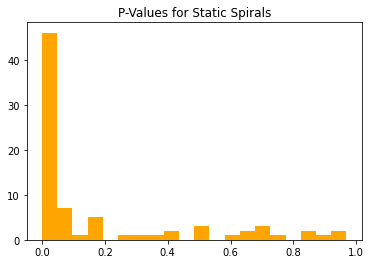

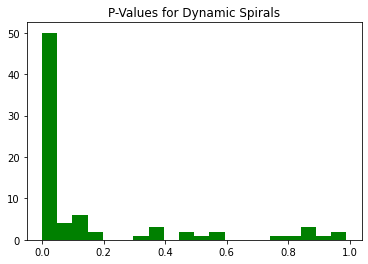

In [ ]:
plt.hist(PValArrStatic, bins = 20, color= 'orange')
plt.title('P-Values for Static Spirals')
plt.show()

plt.hist(PValArrDynamic, bins = 20, color = 'green')
plt.title('P-Values for Dynamic Spirals')
plt.show()

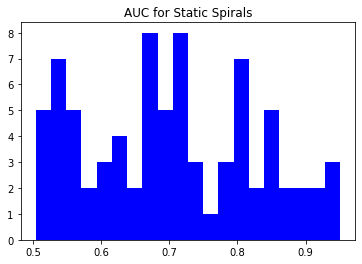

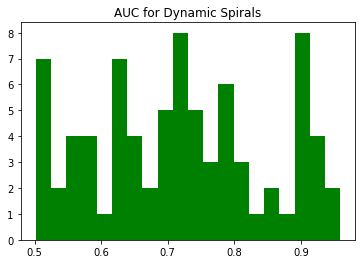

In [ ]:
plt.hist(aucStatic, bins = 20, color = 'blue')
plt.title('AUC for Static Spirals')
plt.show()

plt.hist(aucDynamic, bins = 20, color= 'green')
plt.title('AUC for Dynamic Spirals')
plt.show()

In [ ]:
zipped_lists = zip(aucStatic, df_all_features_dynamic.columns[2:])
sorted_pairs = sorted(zipped_lists, reverse = True)

tuples = zip(*sorted_pairs)
auc_static_sort, static_sort_label = [list(tuple) for tuple in  tuples]

zipped_lists = zip(aucDynamic,  df_all_features_static.columns[2:])
sorted_pairs = sorted(zipped_lists, reverse = True)

tuples = zip(*sorted_pairs)
auc_dynamic_sort, dynamic_sort_label = [list(tuple) for tuple in  tuples]


zipped_lists = zip(PValArrStatic, df_all_features_dynamic.columns[2:])
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
p_static_sort, p_static_sort_label = [list(tuple) for tuple in  tuples]

zipped_lists = zip(PValArrDynamic,  df_all_features_static.columns[2:])
sorted_pairs = sorted(zipped_lists)

tuples = zip(*sorted_pairs)
p_dynamic_sort, p_dynamic_sort_label = [list(tuple) for tuple in  tuples]

In [ ]:
print(auc_static_sort)
print(auc_dynamic_sort)
print(static_sort_label)
print(dynamic_sort_label)

[0.9508196721311475, 0.9420765027322404, 0.9398907103825137, 0.9245901639344263, 0.9202185792349726, 0.8863387978142077, 0.8863387978142077, 0.8688524590163934, 0.8666666666666667, 0.8557377049180328, 0.8502732240437159, 0.848087431693989, 0.8459016393442623, 0.8415300546448088, 0.8273224043715847, 0.819672131147541, 0.8163934426229508, 0.8076502732240437, 0.8076502732240437, 0.8076502732240437, 0.8, 0.8, 0.7945355191256831, 0.7901639344262295, 0.7781420765027323, 0.7770491803278688, 0.7704918032786885, 0.7486338797814208, 0.7387978142076503, 0.7278688524590164, 0.7267759562841529, 0.7213114754098361, 0.7202185792349727, 0.7147540983606557, 0.7125683060109289, 0.7114754098360656, 0.7103825136612022, 0.7103825136612022, 0.7038251366120218, 0.7027322404371584, 0.7016393442622951, 0.692896174863388, 0.6852459016393443, 0.6808743169398908, 0.6808743169398908, 0.6710382513661202, 0.6655737704918033, 0.6633879781420765, 0.6612021857923498, 0.6612021857923498, 0.6612021857923497, 0.6546448087

In [ ]:
cut = 0.9
print(sum(np.array(auc_static_sort) > cut))
print(sum(np.array(auc_dynamic_sort) > cut))

5
11


In [ ]:
print(np.array(auc_static_sort) > cut)

[ True  True  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


In [ ]:
print(p_static_sort)
print(p_dynamic_sort)
print(p_static_sort_label)
print(dynamic_sort_label)

[7.577939003964034e-08, 1.3458237805518004e-07, 1.5510640367545652e-07, 4.1123503158080265e-07, 5.401320446192905e-07, 4.087032299820326e-06, 4.087032299820326e-06, 1.0920513746647285e-05, 1.231171188400697e-05, 2.2204438943674017e-05, 2.9637661162920244e-05, 3.3228466017528136e-05, 3.723006763211768e-05, 4.664583914332034e-05, 9.533516724172415e-05, 0.00013851087640556973, 0.00016216500849568766, 0.0002451688862155429, 0.0002451688862155429, 0.0002451688862155429, 0.00034902603782800185, 0.00034902603782800185, 0.0004470198768439352, 0.0005433077846866823, 0.0009168092446353925, 0.000960549005231745, 0.0012662119761789263, 0.0030513685619716663, 0.0044403261603522684, 0.006636562709765133, 0.006898904379035554, 0.008382871021080705, 0.008710909880105441, 0.01052934884517872, 0.011346540167536938, 0.01177587460759338, 0.01221600551781735, 0.012219556468092387, 0.015089095297322339, 0.01520600011096271, 0.016335427094220246, 0.021622877603556405, 0.027413917907561897, 0.0312861441583302

In [ ]:
cut = 0.05
print(sum(np.array(p_static_sort) < cut))
print(sum(np.array(p_dynamic_sort) < cut))

47
50


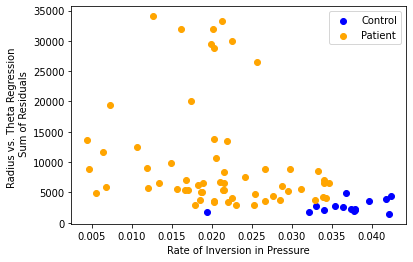

In [ ]:
feature1 = []
feature2 = []
for index, row in df_all_features_static.iterrows():
    feature1.append(row['Rate of Inversion in Pressure'])
    feature2.append(row['RT Reg SumResids'])
plt.scatter(feature1[0:15], feature2[0:15], c = 'blue', label = "Control")
plt.scatter(feature1[15:], feature2[15:], c = 'orange', label = "Patient")
plt.xlabel('Rate of Inversion in Pressure')
plt.ylabel('Radius vs. Theta Regression \n Sum of Residuals')
plt.legend()
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=54ea7590-1f30-42ee-b9c1-c929b94e3f2f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>